# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [ ]:
# can comment out after executing
!unzip processed_celeba_small.zip

In [54]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [107]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import os

In [108]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size),
                                   transforms.ToTensor()])
    
    image_path = "./" + data_dir
    data_path = os.path.join(image_path, "celeba")
    
    dataset = datasets.ImageFolder(data_path, transform)
    
    dataloader = DataLoader(dataset=dataset, shuffle=True, batch_size=batch_size)
    
    
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [109]:
# Define function hyperparameters
batch_size = 20
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

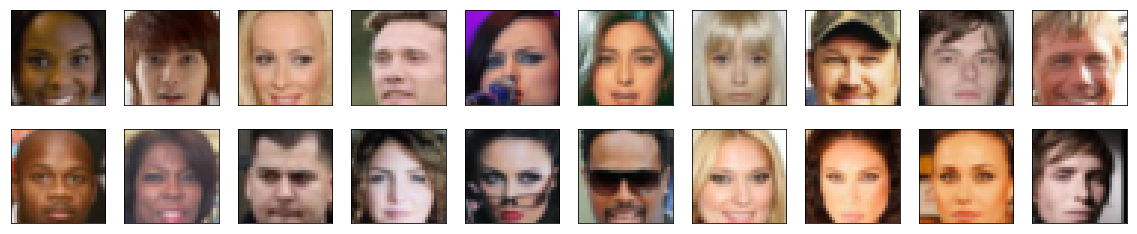

In [110]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [111]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x*(max - min) + min
    return x


In [112]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9765)
Max:  tensor(0.5529)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [113]:
import torch.nn as nn
import torch.nn.functional as F

In [114]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers= []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [115]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = out.view(-1, self.conv_dim*4*4*4)
        out = self.fc(out)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [116]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    trans_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(trans_conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [117]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, width, height)
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        out = F.tanh(self.t_conv3(out))
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [118]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if classname.find("Linear") != -1:
        """
        n = m.in_features
        y = (1.0/np.sqrt(n))
        """
        m.weight.data.normal_(0, 0.02)
        m.bias.data.fill_(0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [119]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [120]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [121]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')
    D = D.cuda()
    G = G.cuda()

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [122]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    loss = torch.mean((D_out - 1)**2)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    loss = torch.mean(D_out**2)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [123]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [124]:
def train(D, G, n_epochs, save_file_name, z_size, d_optimizer, g_optimizer, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            if train_on_gpu:
                real_images = real_images.cuda()
            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            #train with fake images
            #generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            #compute the discriminator losses on fake images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            
            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # train with fake images and flipped labels
            #generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            # compute the discriminator losses on fake images
            # using flipped labels:
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels
            #perform backpropagation
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open(save_file_name, 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [125]:
# set number of epochs 
n_epochs = 50
save_file_name = "train_samples.pkl"

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function

losses = train(D, G, n_epochs, save_file_name, z_size, d_optimizer, g_optimizer, print_every=50)

Epoch [    1/   50] | d_loss: 0.3995 | g_loss: 0.6507
Epoch [    1/   50] | d_loss: 0.1207 | g_loss: 1.0322
Epoch [    1/   50] | d_loss: 0.0785 | g_loss: 1.1392
Epoch [    1/   50] | d_loss: 0.0437 | g_loss: 0.7584
Epoch [    1/   50] | d_loss: 0.0312 | g_loss: 1.1938
Epoch [    1/   50] | d_loss: 0.0711 | g_loss: 0.9219
Epoch [    1/   50] | d_loss: 0.0378 | g_loss: 1.1201
Epoch [    1/   50] | d_loss: 0.0825 | g_loss: 0.8368
Epoch [    1/   50] | d_loss: 0.0963 | g_loss: 0.9350
Epoch [    1/   50] | d_loss: 0.0867 | g_loss: 0.8299
Epoch [    1/   50] | d_loss: 0.1739 | g_loss: 0.9291
Epoch [    1/   50] | d_loss: 0.1270 | g_loss: 0.8746
Epoch [    1/   50] | d_loss: 0.1088 | g_loss: 1.3343
Epoch [    1/   50] | d_loss: 0.1555 | g_loss: 0.6705
Epoch [    1/   50] | d_loss: 0.0910 | g_loss: 0.6156
Epoch [    1/   50] | d_loss: 0.1495 | g_loss: 0.6354
Epoch [    1/   50] | d_loss: 0.1160 | g_loss: 1.2427
Epoch [    1/   50] | d_loss: 0.1609 | g_loss: 0.9336
Epoch [    1/   50] | d_loss

Epoch [    3/   50] | d_loss: 0.3511 | g_loss: 0.3468
Epoch [    3/   50] | d_loss: 0.2266 | g_loss: 1.2441
Epoch [    3/   50] | d_loss: 0.2950 | g_loss: 0.3404
Epoch [    3/   50] | d_loss: 0.1792 | g_loss: 0.7242
Epoch [    3/   50] | d_loss: 0.5385 | g_loss: 0.5842
Epoch [    3/   50] | d_loss: 0.3111 | g_loss: 0.7242
Epoch [    3/   50] | d_loss: 0.9627 | g_loss: 0.4587
Epoch [    3/   50] | d_loss: 0.0981 | g_loss: 1.1665
Epoch [    3/   50] | d_loss: 0.3087 | g_loss: 0.4986
Epoch [    3/   50] | d_loss: 0.2920 | g_loss: 0.2614
Epoch [    3/   50] | d_loss: 0.1601 | g_loss: 0.3940
Epoch [    3/   50] | d_loss: 0.3531 | g_loss: 0.7677
Epoch [    3/   50] | d_loss: 0.2509 | g_loss: 0.9940
Epoch [    3/   50] | d_loss: 0.2991 | g_loss: 1.0872
Epoch [    3/   50] | d_loss: 0.1887 | g_loss: 0.5751
Epoch [    3/   50] | d_loss: 0.1305 | g_loss: 1.0340
Epoch [    3/   50] | d_loss: 0.3524 | g_loss: 0.5557
Epoch [    3/   50] | d_loss: 0.2233 | g_loss: 0.6715
Epoch [    3/   50] | d_loss

Epoch [    6/   50] | d_loss: 0.3003 | g_loss: 0.6431
Epoch [    6/   50] | d_loss: 0.2449 | g_loss: 0.4514
Epoch [    6/   50] | d_loss: 0.2483 | g_loss: 0.5574
Epoch [    6/   50] | d_loss: 0.2920 | g_loss: 0.7657
Epoch [    6/   50] | d_loss: 0.0816 | g_loss: 0.8001
Epoch [    6/   50] | d_loss: 0.2170 | g_loss: 0.8334
Epoch [    6/   50] | d_loss: 0.2228 | g_loss: 0.7612
Epoch [    6/   50] | d_loss: 0.3366 | g_loss: 0.5308
Epoch [    6/   50] | d_loss: 0.1792 | g_loss: 0.7176
Epoch [    6/   50] | d_loss: 0.0703 | g_loss: 1.1117
Epoch [    6/   50] | d_loss: 0.2908 | g_loss: 0.7499
Epoch [    6/   50] | d_loss: 0.2302 | g_loss: 0.8155
Epoch [    6/   50] | d_loss: 0.2945 | g_loss: 0.8071
Epoch [    6/   50] | d_loss: 0.2332 | g_loss: 0.6349
Epoch [    6/   50] | d_loss: 0.1382 | g_loss: 0.7248
Epoch [    6/   50] | d_loss: 0.2440 | g_loss: 0.4860
Epoch [    6/   50] | d_loss: 0.3075 | g_loss: 0.4518
Epoch [    6/   50] | d_loss: 0.3094 | g_loss: 0.5601
Epoch [    6/   50] | d_loss

Epoch [    8/   50] | d_loss: 0.1580 | g_loss: 0.7772
Epoch [    8/   50] | d_loss: 0.2922 | g_loss: 0.5407
Epoch [    8/   50] | d_loss: 0.1283 | g_loss: 0.9984
Epoch [    8/   50] | d_loss: 0.1004 | g_loss: 0.6913
Epoch [    8/   50] | d_loss: 0.2152 | g_loss: 0.4483
Epoch [    8/   50] | d_loss: 0.1380 | g_loss: 0.2934
Epoch [    8/   50] | d_loss: 0.1693 | g_loss: 0.4806
Epoch [    8/   50] | d_loss: 0.1587 | g_loss: 0.6855
Epoch [    9/   50] | d_loss: 0.5264 | g_loss: 0.1944
Epoch [    9/   50] | d_loss: 0.2384 | g_loss: 0.6340
Epoch [    9/   50] | d_loss: 0.2097 | g_loss: 0.4463
Epoch [    9/   50] | d_loss: 0.1623 | g_loss: 0.6690
Epoch [    9/   50] | d_loss: 0.1660 | g_loss: 0.4041
Epoch [    9/   50] | d_loss: 0.3058 | g_loss: 0.8047
Epoch [    9/   50] | d_loss: 0.2205 | g_loss: 0.3454
Epoch [    9/   50] | d_loss: 0.1197 | g_loss: 0.8852
Epoch [    9/   50] | d_loss: 0.2768 | g_loss: 1.0630
Epoch [    9/   50] | d_loss: 0.1818 | g_loss: 0.6760
Epoch [    9/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.1062 | g_loss: 0.4461
Epoch [   11/   50] | d_loss: 0.4005 | g_loss: 0.9412
Epoch [   11/   50] | d_loss: 0.0820 | g_loss: 1.0892
Epoch [   11/   50] | d_loss: 0.0937 | g_loss: 0.6014
Epoch [   11/   50] | d_loss: 0.1167 | g_loss: 0.5923
Epoch [   11/   50] | d_loss: 0.0875 | g_loss: 0.3734
Epoch [   11/   50] | d_loss: 0.1589 | g_loss: 0.9678
Epoch [   11/   50] | d_loss: 0.1620 | g_loss: 0.7047
Epoch [   11/   50] | d_loss: 0.3044 | g_loss: 0.4928
Epoch [   11/   50] | d_loss: 0.0811 | g_loss: 0.9278
Epoch [   11/   50] | d_loss: 0.0744 | g_loss: 0.7056
Epoch [   11/   50] | d_loss: 0.1026 | g_loss: 0.7606
Epoch [   11/   50] | d_loss: 0.1520 | g_loss: 0.8055
Epoch [   11/   50] | d_loss: 0.1935 | g_loss: 0.7132
Epoch [   11/   50] | d_loss: 0.1340 | g_loss: 0.6673
Epoch [   11/   50] | d_loss: 0.1167 | g_loss: 0.7830
Epoch [   11/   50] | d_loss: 0.1803 | g_loss: 0.5744
Epoch [   11/   50] | d_loss: 0.0830 | g_loss: 1.0504
Epoch [   11/   50] | d_loss

Epoch [   14/   50] | d_loss: 0.6533 | g_loss: 0.6075
Epoch [   14/   50] | d_loss: 0.2192 | g_loss: 0.8773
Epoch [   14/   50] | d_loss: 0.1523 | g_loss: 0.6834
Epoch [   14/   50] | d_loss: 0.2727 | g_loss: 1.3273
Epoch [   14/   50] | d_loss: 0.1181 | g_loss: 1.1060
Epoch [   14/   50] | d_loss: 0.2776 | g_loss: 0.8579
Epoch [   14/   50] | d_loss: 0.2719 | g_loss: 1.3281
Epoch [   14/   50] | d_loss: 0.0610 | g_loss: 1.1043
Epoch [   14/   50] | d_loss: 0.1391 | g_loss: 0.6280
Epoch [   14/   50] | d_loss: 0.0945 | g_loss: 0.9598
Epoch [   14/   50] | d_loss: 0.1353 | g_loss: 0.5944
Epoch [   14/   50] | d_loss: 0.1302 | g_loss: 0.7233
Epoch [   14/   50] | d_loss: 0.1693 | g_loss: 0.4446
Epoch [   14/   50] | d_loss: 0.3006 | g_loss: 0.6876
Epoch [   14/   50] | d_loss: 0.0833 | g_loss: 0.9932
Epoch [   14/   50] | d_loss: 0.1811 | g_loss: 0.7600
Epoch [   14/   50] | d_loss: 0.1659 | g_loss: 0.9795
Epoch [   14/   50] | d_loss: 0.1156 | g_loss: 0.8898
Epoch [   14/   50] | d_loss

Epoch [   16/   50] | d_loss: 0.2056 | g_loss: 1.2537
Epoch [   16/   50] | d_loss: 0.1277 | g_loss: 0.8831
Epoch [   16/   50] | d_loss: 0.3164 | g_loss: 1.1224
Epoch [   16/   50] | d_loss: 0.2822 | g_loss: 0.4771
Epoch [   16/   50] | d_loss: 0.4578 | g_loss: 0.8911
Epoch [   16/   50] | d_loss: 0.0922 | g_loss: 0.8369
Epoch [   16/   50] | d_loss: 0.1670 | g_loss: 0.3497
Epoch [   16/   50] | d_loss: 0.1844 | g_loss: 0.5384
Epoch [   16/   50] | d_loss: 0.1021 | g_loss: 1.3961
Epoch [   16/   50] | d_loss: 0.2611 | g_loss: 0.4453
Epoch [   16/   50] | d_loss: 0.1137 | g_loss: 0.6647
Epoch [   16/   50] | d_loss: 0.0917 | g_loss: 0.5945
Epoch [   16/   50] | d_loss: 0.2433 | g_loss: 0.5185
Epoch [   16/   50] | d_loss: 0.1575 | g_loss: 0.9266
Epoch [   16/   50] | d_loss: 0.1997 | g_loss: 0.6636
Epoch [   16/   50] | d_loss: 0.3109 | g_loss: 0.7187
Epoch [   17/   50] | d_loss: 0.1442 | g_loss: 0.6562
Epoch [   17/   50] | d_loss: 0.1818 | g_loss: 0.8997
Epoch [   17/   50] | d_loss

Epoch [   19/   50] | d_loss: 0.0744 | g_loss: 0.7309
Epoch [   19/   50] | d_loss: 0.0745 | g_loss: 0.7227
Epoch [   19/   50] | d_loss: 0.1209 | g_loss: 0.5846
Epoch [   19/   50] | d_loss: 0.1818 | g_loss: 0.7208
Epoch [   19/   50] | d_loss: 0.1300 | g_loss: 0.9440
Epoch [   19/   50] | d_loss: 0.0778 | g_loss: 0.8968
Epoch [   19/   50] | d_loss: 0.0669 | g_loss: 0.7715
Epoch [   19/   50] | d_loss: 0.1196 | g_loss: 1.0135
Epoch [   19/   50] | d_loss: 0.1233 | g_loss: 0.6535
Epoch [   19/   50] | d_loss: 0.2266 | g_loss: 0.5725
Epoch [   19/   50] | d_loss: 0.1727 | g_loss: 0.3359
Epoch [   19/   50] | d_loss: 0.1043 | g_loss: 0.4953
Epoch [   19/   50] | d_loss: 0.2052 | g_loss: 0.4148
Epoch [   19/   50] | d_loss: 0.0832 | g_loss: 0.7567
Epoch [   19/   50] | d_loss: 0.0684 | g_loss: 0.7405
Epoch [   19/   50] | d_loss: 0.1243 | g_loss: 0.6850
Epoch [   19/   50] | d_loss: 0.1895 | g_loss: 0.8941
Epoch [   19/   50] | d_loss: 0.1166 | g_loss: 1.4279
Epoch [   19/   50] | d_loss

Epoch [   21/   50] | d_loss: 0.1287 | g_loss: 0.6018
Epoch [   21/   50] | d_loss: 0.1227 | g_loss: 0.8016
Epoch [   22/   50] | d_loss: 0.1649 | g_loss: 0.5420
Epoch [   22/   50] | d_loss: 0.1539 | g_loss: 0.6689
Epoch [   22/   50] | d_loss: 0.0732 | g_loss: 0.7397
Epoch [   22/   50] | d_loss: 0.1059 | g_loss: 0.9897
Epoch [   22/   50] | d_loss: 0.0860 | g_loss: 1.0367
Epoch [   22/   50] | d_loss: 0.1839 | g_loss: 0.4602
Epoch [   22/   50] | d_loss: 0.2249 | g_loss: 1.2278
Epoch [   22/   50] | d_loss: 0.1703 | g_loss: 0.8668
Epoch [   22/   50] | d_loss: 0.1547 | g_loss: 0.8280
Epoch [   22/   50] | d_loss: 0.1022 | g_loss: 0.9874
Epoch [   22/   50] | d_loss: 0.2283 | g_loss: 0.9127
Epoch [   22/   50] | d_loss: 0.1276 | g_loss: 0.4808
Epoch [   22/   50] | d_loss: 0.1777 | g_loss: 0.5505
Epoch [   22/   50] | d_loss: 0.1514 | g_loss: 0.4607
Epoch [   22/   50] | d_loss: 0.1221 | g_loss: 0.9905
Epoch [   22/   50] | d_loss: 0.0902 | g_loss: 0.7983
Epoch [   22/   50] | d_loss

Epoch [   24/   50] | d_loss: 0.2030 | g_loss: 0.7178
Epoch [   24/   50] | d_loss: 0.1051 | g_loss: 0.6376
Epoch [   24/   50] | d_loss: 0.1437 | g_loss: 0.7570
Epoch [   24/   50] | d_loss: 0.0596 | g_loss: 0.8448
Epoch [   24/   50] | d_loss: 0.1146 | g_loss: 0.6844
Epoch [   24/   50] | d_loss: 0.1477 | g_loss: 0.5435
Epoch [   24/   50] | d_loss: 0.0815 | g_loss: 0.6646
Epoch [   24/   50] | d_loss: 0.4303 | g_loss: 0.1616
Epoch [   24/   50] | d_loss: 0.0986 | g_loss: 1.0016
Epoch [   24/   50] | d_loss: 0.1132 | g_loss: 0.6252
Epoch [   24/   50] | d_loss: 0.2238 | g_loss: 0.9821
Epoch [   24/   50] | d_loss: 0.1422 | g_loss: 0.5991
Epoch [   24/   50] | d_loss: 0.4044 | g_loss: 0.6476
Epoch [   24/   50] | d_loss: 0.0895 | g_loss: 1.0366
Epoch [   24/   50] | d_loss: 0.0802 | g_loss: 0.8392
Epoch [   24/   50] | d_loss: 0.0327 | g_loss: 1.3741
Epoch [   24/   50] | d_loss: 0.0758 | g_loss: 1.1789
Epoch [   24/   50] | d_loss: 0.3913 | g_loss: 0.4034
Epoch [   24/   50] | d_loss

Epoch [   27/   50] | d_loss: 0.0705 | g_loss: 1.2378
Epoch [   27/   50] | d_loss: 0.0951 | g_loss: 0.5300
Epoch [   27/   50] | d_loss: 0.1095 | g_loss: 0.7068
Epoch [   27/   50] | d_loss: 0.0973 | g_loss: 1.5322
Epoch [   27/   50] | d_loss: 0.1954 | g_loss: 0.8280
Epoch [   27/   50] | d_loss: 0.0460 | g_loss: 0.6771
Epoch [   27/   50] | d_loss: 0.1217 | g_loss: 1.2212
Epoch [   27/   50] | d_loss: 0.1506 | g_loss: 1.5063
Epoch [   27/   50] | d_loss: 0.1498 | g_loss: 0.9812
Epoch [   27/   50] | d_loss: 0.1122 | g_loss: 0.6183
Epoch [   27/   50] | d_loss: 0.1805 | g_loss: 0.7842
Epoch [   27/   50] | d_loss: 0.1197 | g_loss: 0.6333
Epoch [   27/   50] | d_loss: 0.0826 | g_loss: 0.7383
Epoch [   27/   50] | d_loss: 0.1010 | g_loss: 0.6157
Epoch [   27/   50] | d_loss: 0.0920 | g_loss: 0.7343
Epoch [   27/   50] | d_loss: 0.0696 | g_loss: 1.0958
Epoch [   27/   50] | d_loss: 0.1144 | g_loss: 0.6636
Epoch [   27/   50] | d_loss: 0.1250 | g_loss: 0.7362
Epoch [   27/   50] | d_loss

Epoch [   29/   50] | d_loss: 0.1917 | g_loss: 0.6137
Epoch [   29/   50] | d_loss: 0.1100 | g_loss: 0.8269
Epoch [   29/   50] | d_loss: 0.0543 | g_loss: 1.0671
Epoch [   29/   50] | d_loss: 0.0737 | g_loss: 1.1604
Epoch [   29/   50] | d_loss: 0.1001 | g_loss: 0.7858
Epoch [   29/   50] | d_loss: 0.0400 | g_loss: 0.8536
Epoch [   29/   50] | d_loss: 0.1166 | g_loss: 1.1568
Epoch [   29/   50] | d_loss: 0.0978 | g_loss: 0.5804
Epoch [   29/   50] | d_loss: 0.0621 | g_loss: 0.7361
Epoch [   29/   50] | d_loss: 0.1551 | g_loss: 0.9189
Epoch [   30/   50] | d_loss: 0.2731 | g_loss: 0.7086
Epoch [   30/   50] | d_loss: 0.1304 | g_loss: 0.8873
Epoch [   30/   50] | d_loss: 0.1163 | g_loss: 1.0696
Epoch [   30/   50] | d_loss: 0.1046 | g_loss: 0.8208
Epoch [   30/   50] | d_loss: 0.1667 | g_loss: 0.7705
Epoch [   30/   50] | d_loss: 0.1098 | g_loss: 1.1187
Epoch [   30/   50] | d_loss: 0.0729 | g_loss: 0.4864
Epoch [   30/   50] | d_loss: 0.1091 | g_loss: 1.2366
Epoch [   30/   50] | d_loss

Epoch [   32/   50] | d_loss: 0.0514 | g_loss: 1.0108
Epoch [   32/   50] | d_loss: 0.0710 | g_loss: 0.7872
Epoch [   32/   50] | d_loss: 0.1070 | g_loss: 1.4765
Epoch [   32/   50] | d_loss: 0.0546 | g_loss: 1.4008
Epoch [   32/   50] | d_loss: 0.0911 | g_loss: 1.1342
Epoch [   32/   50] | d_loss: 0.1047 | g_loss: 1.0737
Epoch [   32/   50] | d_loss: 0.1081 | g_loss: 0.5775
Epoch [   32/   50] | d_loss: 0.0856 | g_loss: 1.2189
Epoch [   32/   50] | d_loss: 0.3904 | g_loss: 0.3915
Epoch [   32/   50] | d_loss: 0.1199 | g_loss: 0.9236
Epoch [   32/   50] | d_loss: 0.1290 | g_loss: 0.7234
Epoch [   32/   50] | d_loss: 0.1002 | g_loss: 1.1472
Epoch [   32/   50] | d_loss: 0.0423 | g_loss: 0.7973
Epoch [   32/   50] | d_loss: 0.1381 | g_loss: 1.0552
Epoch [   32/   50] | d_loss: 0.1633 | g_loss: 0.7366
Epoch [   32/   50] | d_loss: 0.0512 | g_loss: 0.7840
Epoch [   32/   50] | d_loss: 0.2382 | g_loss: 1.2031
Epoch [   32/   50] | d_loss: 0.1583 | g_loss: 0.8577
Epoch [   32/   50] | d_loss

Epoch [   35/   50] | d_loss: 0.0324 | g_loss: 0.8363
Epoch [   35/   50] | d_loss: 0.1136 | g_loss: 1.2457
Epoch [   35/   50] | d_loss: 0.1186 | g_loss: 1.2433
Epoch [   35/   50] | d_loss: 0.0691 | g_loss: 0.7259
Epoch [   35/   50] | d_loss: 0.0676 | g_loss: 1.1478
Epoch [   35/   50] | d_loss: 0.0767 | g_loss: 1.1278
Epoch [   35/   50] | d_loss: 0.1002 | g_loss: 0.8634
Epoch [   35/   50] | d_loss: 0.0789 | g_loss: 0.5878
Epoch [   35/   50] | d_loss: 0.1283 | g_loss: 0.6546
Epoch [   35/   50] | d_loss: 0.0818 | g_loss: 0.9691
Epoch [   35/   50] | d_loss: 0.0534 | g_loss: 0.9482
Epoch [   35/   50] | d_loss: 0.0752 | g_loss: 0.7626
Epoch [   35/   50] | d_loss: 0.0973 | g_loss: 1.0600
Epoch [   35/   50] | d_loss: 0.0965 | g_loss: 1.3536
Epoch [   35/   50] | d_loss: 0.0352 | g_loss: 0.8039
Epoch [   35/   50] | d_loss: 0.1081 | g_loss: 1.2297
Epoch [   35/   50] | d_loss: 0.0465 | g_loss: 1.0555
Epoch [   35/   50] | d_loss: 0.1347 | g_loss: 1.6201
Epoch [   35/   50] | d_loss

Epoch [   37/   50] | d_loss: 0.0888 | g_loss: 0.8811
Epoch [   37/   50] | d_loss: 0.1130 | g_loss: 0.6022
Epoch [   37/   50] | d_loss: 0.0313 | g_loss: 1.0966
Epoch [   37/   50] | d_loss: 0.1135 | g_loss: 0.6341
Epoch [   37/   50] | d_loss: 0.0891 | g_loss: 1.0641
Epoch [   37/   50] | d_loss: 0.1211 | g_loss: 1.3355
Epoch [   37/   50] | d_loss: 0.3530 | g_loss: 1.2293
Epoch [   37/   50] | d_loss: 0.1374 | g_loss: 0.7838
Epoch [   37/   50] | d_loss: 0.0918 | g_loss: 0.7733
Epoch [   37/   50] | d_loss: 0.0507 | g_loss: 0.9221
Epoch [   37/   50] | d_loss: 0.0413 | g_loss: 0.9580
Epoch [   37/   50] | d_loss: 0.0634 | g_loss: 1.1472
Epoch [   37/   50] | d_loss: 0.0511 | g_loss: 1.2816
Epoch [   37/   50] | d_loss: 0.0856 | g_loss: 0.8586
Epoch [   37/   50] | d_loss: 0.0622 | g_loss: 0.8896
Epoch [   37/   50] | d_loss: 0.1818 | g_loss: 0.7609
Epoch [   37/   50] | d_loss: 0.0815 | g_loss: 0.6422
Epoch [   37/   50] | d_loss: 0.0922 | g_loss: 0.9658
Epoch [   38/   50] | d_loss

Epoch [   40/   50] | d_loss: 0.0669 | g_loss: 0.9505
Epoch [   40/   50] | d_loss: 0.1163 | g_loss: 0.7980
Epoch [   40/   50] | d_loss: 0.0612 | g_loss: 0.8535
Epoch [   40/   50] | d_loss: 0.0952 | g_loss: 0.6689
Epoch [   40/   50] | d_loss: 0.0862 | g_loss: 1.2945
Epoch [   40/   50] | d_loss: 0.1092 | g_loss: 1.0440
Epoch [   40/   50] | d_loss: 0.0779 | g_loss: 0.9223
Epoch [   40/   50] | d_loss: 0.1193 | g_loss: 0.5572
Epoch [   40/   50] | d_loss: 0.0217 | g_loss: 1.0973
Epoch [   40/   50] | d_loss: 0.3402 | g_loss: 1.5763
Epoch [   40/   50] | d_loss: 0.0735 | g_loss: 0.8581
Epoch [   40/   50] | d_loss: 0.0500 | g_loss: 0.8297
Epoch [   40/   50] | d_loss: 0.0959 | g_loss: 1.2327
Epoch [   40/   50] | d_loss: 0.1225 | g_loss: 0.6625
Epoch [   40/   50] | d_loss: 0.0833 | g_loss: 0.9621
Epoch [   40/   50] | d_loss: 0.1902 | g_loss: 0.3121
Epoch [   40/   50] | d_loss: 0.1369 | g_loss: 0.9179
Epoch [   40/   50] | d_loss: 0.0524 | g_loss: 0.9288
Epoch [   40/   50] | d_loss

Epoch [   42/   50] | d_loss: 0.0635 | g_loss: 1.0955
Epoch [   42/   50] | d_loss: 0.0393 | g_loss: 1.1109
Epoch [   42/   50] | d_loss: 0.0507 | g_loss: 0.8111
Epoch [   42/   50] | d_loss: 0.0651 | g_loss: 1.1320
Epoch [   43/   50] | d_loss: 0.0677 | g_loss: 0.4923
Epoch [   43/   50] | d_loss: 0.0600 | g_loss: 0.7889
Epoch [   43/   50] | d_loss: 0.0391 | g_loss: 0.8905
Epoch [   43/   50] | d_loss: 0.2165 | g_loss: 0.8124
Epoch [   43/   50] | d_loss: 0.1301 | g_loss: 0.9844
Epoch [   43/   50] | d_loss: 0.0537 | g_loss: 0.9386
Epoch [   43/   50] | d_loss: 0.0442 | g_loss: 1.0012
Epoch [   43/   50] | d_loss: 0.0931 | g_loss: 0.8852
Epoch [   43/   50] | d_loss: 0.0672 | g_loss: 1.2956
Epoch [   43/   50] | d_loss: 0.0479 | g_loss: 0.5715
Epoch [   43/   50] | d_loss: 0.1658 | g_loss: 1.2991
Epoch [   43/   50] | d_loss: 0.0867 | g_loss: 0.4565
Epoch [   43/   50] | d_loss: 0.0465 | g_loss: 0.6757
Epoch [   43/   50] | d_loss: 0.1175 | g_loss: 0.8539
Epoch [   43/   50] | d_loss

Epoch [   45/   50] | d_loss: 0.0607 | g_loss: 1.0200
Epoch [   45/   50] | d_loss: 0.0319 | g_loss: 0.9978
Epoch [   45/   50] | d_loss: 0.0765 | g_loss: 1.3744
Epoch [   45/   50] | d_loss: 0.1272 | g_loss: 1.1842
Epoch [   45/   50] | d_loss: 0.0519 | g_loss: 0.6894
Epoch [   45/   50] | d_loss: 0.1481 | g_loss: 0.6919
Epoch [   45/   50] | d_loss: 0.0707 | g_loss: 0.9367
Epoch [   45/   50] | d_loss: 0.2035 | g_loss: 1.4347
Epoch [   45/   50] | d_loss: 0.0419 | g_loss: 0.9446
Epoch [   45/   50] | d_loss: 0.0780 | g_loss: 0.9866
Epoch [   45/   50] | d_loss: 0.1283 | g_loss: 0.9479
Epoch [   45/   50] | d_loss: 0.0266 | g_loss: 1.1165
Epoch [   45/   50] | d_loss: 0.0362 | g_loss: 0.8202
Epoch [   45/   50] | d_loss: 0.1448 | g_loss: 1.0062
Epoch [   45/   50] | d_loss: 0.0813 | g_loss: 1.1747
Epoch [   45/   50] | d_loss: 0.0976 | g_loss: 0.6930
Epoch [   45/   50] | d_loss: 0.0668 | g_loss: 0.6015
Epoch [   45/   50] | d_loss: 0.0396 | g_loss: 0.6591
Epoch [   45/   50] | d_loss

Epoch [   48/   50] | d_loss: 0.0645 | g_loss: 0.7367
Epoch [   48/   50] | d_loss: 0.0317 | g_loss: 0.6847
Epoch [   48/   50] | d_loss: 0.0461 | g_loss: 0.7017
Epoch [   48/   50] | d_loss: 0.0721 | g_loss: 0.9451
Epoch [   48/   50] | d_loss: 0.1108 | g_loss: 0.9005
Epoch [   48/   50] | d_loss: 0.0767 | g_loss: 0.7711
Epoch [   48/   50] | d_loss: 0.0912 | g_loss: 0.8880
Epoch [   48/   50] | d_loss: 0.0540 | g_loss: 1.2354
Epoch [   48/   50] | d_loss: 0.0737 | g_loss: 0.5699
Epoch [   48/   50] | d_loss: 0.0381 | g_loss: 0.9424
Epoch [   48/   50] | d_loss: 0.1661 | g_loss: 1.8606
Epoch [   48/   50] | d_loss: 0.3662 | g_loss: 1.7042
Epoch [   48/   50] | d_loss: 0.0769 | g_loss: 0.6358
Epoch [   48/   50] | d_loss: 0.0603 | g_loss: 0.5237
Epoch [   48/   50] | d_loss: 0.0483 | g_loss: 0.7991
Epoch [   48/   50] | d_loss: 0.0520 | g_loss: 1.1363
Epoch [   48/   50] | d_loss: 0.1102 | g_loss: 1.0539
Epoch [   48/   50] | d_loss: 0.0661 | g_loss: 0.5677
Epoch [   48/   50] | d_loss

Epoch [   50/   50] | d_loss: 0.0646 | g_loss: 1.2818
Epoch [   50/   50] | d_loss: 0.1169 | g_loss: 0.8727
Epoch [   50/   50] | d_loss: 0.0343 | g_loss: 1.4266
Epoch [   50/   50] | d_loss: 0.1424 | g_loss: 1.0926
Epoch [   50/   50] | d_loss: 0.2849 | g_loss: 0.4847
Epoch [   50/   50] | d_loss: 0.1279 | g_loss: 0.5252
Epoch [   50/   50] | d_loss: 0.0458 | g_loss: 0.7793
Epoch [   50/   50] | d_loss: 0.0659 | g_loss: 1.1105
Epoch [   50/   50] | d_loss: 0.0658 | g_loss: 1.1371
Epoch [   50/   50] | d_loss: 0.0608 | g_loss: 1.2026
Epoch [   50/   50] | d_loss: 0.0616 | g_loss: 0.5880
Epoch [   50/   50] | d_loss: 0.0827 | g_loss: 0.9782


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

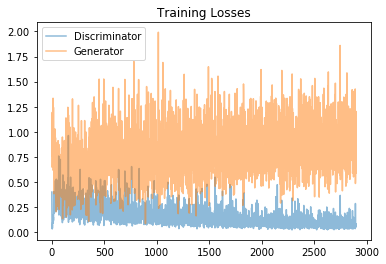

In [126]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [128]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [129]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

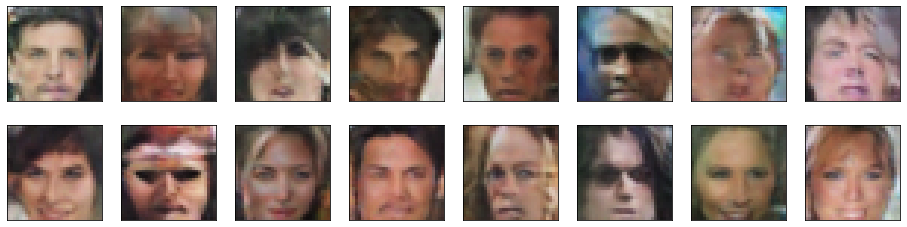

In [130]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)


The images generated looks blurry with some deformations in the borders of the face. However, it is perceptible the human face.

* As the dataset is biased, we won't find generated faces for black people, because the model won't learn those kind of faces due to the lack of those kind of images in dataset. So, in order to avoid this problem we should add more images for people around the world.

* We tested with 3 layers in the Discriminator and 3 layers in Generator and the results looks good. However, we can try increasing those layers.

* We tested with the following optimization hyperparameters:
>lr = 0.0002
beta1 = 0.5
beta2 = 0.999
n_epochs = 50
batch_size = 20

* We also tested with the following model hyperparameters:
>Number of layers (Discriminator Network) = 3
Number of layers (Generator Network) = 3


## Configuration 2: Changing Hyperparameters - epochs = 70

In [133]:
# Define model hyperparams
d_conv_dim2 = 32
g_conv_dim2 = 32
z_size2 = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D2, G2 = build_network(d_conv_dim2, g_conv_dim2, z_size2)

if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')
    D2 = D2.cuda()
    G2 = G2.cuda()

# reducing by order 10 the lr
lr2 = 0.0002
beta1 = 0.5
beta2 = 0.999
d_optimizer2 = optim.Adam(D2.parameters(), lr2, [beta1, beta2])
g_optimizer2 = optim.Adam(G2.parameters(), lr2, [beta1, beta2])

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

In [135]:
# set number of epochs 
import time
n_epochs2 = 70
save_file_name2 = "train_samples2.pkl"

start = time.time()

losses2 = train(D2, G2, n_epochs2, save_file_name2, z_size2, d_optimizer2, g_optimizer2, print_every=50)
end = time.time()
elapsed_time = end - start
print("elapsed_time: {} min, {} sec".format(elapsed_time//60, elapsed_time))

Epoch [    1/   70] | d_loss: 0.6751 | g_loss: 0.5819
Epoch [    1/   70] | d_loss: 0.1643 | g_loss: 1.4680
Epoch [    1/   70] | d_loss: 0.0575 | g_loss: 1.1295
Epoch [    1/   70] | d_loss: 0.0321 | g_loss: 1.1628
Epoch [    1/   70] | d_loss: 0.1425 | g_loss: 1.4050
Epoch [    1/   70] | d_loss: 0.1295 | g_loss: 0.7000
Epoch [    1/   70] | d_loss: 0.0808 | g_loss: 1.0860
Epoch [    1/   70] | d_loss: 0.1472 | g_loss: 0.6035
Epoch [    1/   70] | d_loss: 0.0764 | g_loss: 1.0773
Epoch [    1/   70] | d_loss: 0.1641 | g_loss: 0.9038
Epoch [    1/   70] | d_loss: 0.1598 | g_loss: 0.7168
Epoch [    1/   70] | d_loss: 0.3377 | g_loss: 0.8914
Epoch [    1/   70] | d_loss: 0.1748 | g_loss: 0.6085
Epoch [    1/   70] | d_loss: 0.0874 | g_loss: 0.9402
Epoch [    1/   70] | d_loss: 0.2574 | g_loss: 1.0035
Epoch [    1/   70] | d_loss: 0.1270 | g_loss: 0.7045
Epoch [    1/   70] | d_loss: 0.1287 | g_loss: 0.6207
Epoch [    1/   70] | d_loss: 0.1864 | g_loss: 0.9797
Epoch [    1/   70] | d_loss

Epoch [    3/   70] | d_loss: 0.1934 | g_loss: 0.2653
Epoch [    3/   70] | d_loss: 0.2721 | g_loss: 0.9026
Epoch [    3/   70] | d_loss: 0.2659 | g_loss: 0.7259
Epoch [    3/   70] | d_loss: 0.3349 | g_loss: 0.7322
Epoch [    3/   70] | d_loss: 0.3270 | g_loss: 0.2008
Epoch [    3/   70] | d_loss: 0.4105 | g_loss: 1.0638
Epoch [    3/   70] | d_loss: 0.1933 | g_loss: 0.7929
Epoch [    3/   70] | d_loss: 0.5231 | g_loss: 1.1492
Epoch [    3/   70] | d_loss: 0.4933 | g_loss: 0.6388
Epoch [    3/   70] | d_loss: 0.4018 | g_loss: 0.6681
Epoch [    3/   70] | d_loss: 0.6145 | g_loss: 0.2770
Epoch [    3/   70] | d_loss: 0.2662 | g_loss: 0.4891
Epoch [    3/   70] | d_loss: 0.2549 | g_loss: 0.5835
Epoch [    3/   70] | d_loss: 0.1592 | g_loss: 0.5605
Epoch [    3/   70] | d_loss: 0.0775 | g_loss: 0.9486
Epoch [    3/   70] | d_loss: 0.2612 | g_loss: 1.1265
Epoch [    3/   70] | d_loss: 0.1573 | g_loss: 0.7527
Epoch [    3/   70] | d_loss: 0.2392 | g_loss: 0.6827
Epoch [    3/   70] | d_loss

Epoch [    6/   70] | d_loss: 0.2046 | g_loss: 0.3119
Epoch [    6/   70] | d_loss: 0.2910 | g_loss: 0.3792
Epoch [    6/   70] | d_loss: 0.2254 | g_loss: 0.7660
Epoch [    6/   70] | d_loss: 0.2604 | g_loss: 0.2720
Epoch [    6/   70] | d_loss: 0.1409 | g_loss: 0.8055
Epoch [    6/   70] | d_loss: 0.2676 | g_loss: 0.6303
Epoch [    6/   70] | d_loss: 0.1622 | g_loss: 0.7138
Epoch [    6/   70] | d_loss: 0.4030 | g_loss: 0.5462
Epoch [    6/   70] | d_loss: 0.1967 | g_loss: 0.4032
Epoch [    6/   70] | d_loss: 0.1659 | g_loss: 0.8676
Epoch [    6/   70] | d_loss: 0.3267 | g_loss: 0.4169
Epoch [    6/   70] | d_loss: 0.2184 | g_loss: 0.9465
Epoch [    6/   70] | d_loss: 0.1269 | g_loss: 0.6105
Epoch [    6/   70] | d_loss: 0.1602 | g_loss: 0.5674
Epoch [    6/   70] | d_loss: 0.0559 | g_loss: 1.4434
Epoch [    6/   70] | d_loss: 0.4363 | g_loss: 0.6108
Epoch [    6/   70] | d_loss: 0.2889 | g_loss: 0.8486
Epoch [    6/   70] | d_loss: 0.3871 | g_loss: 0.5357
Epoch [    6/   70] | d_loss

Epoch [    8/   70] | d_loss: 0.1598 | g_loss: 0.4882
Epoch [    8/   70] | d_loss: 0.0697 | g_loss: 0.6370
Epoch [    8/   70] | d_loss: 0.2314 | g_loss: 0.4622
Epoch [    8/   70] | d_loss: 0.2167 | g_loss: 0.8879
Epoch [    8/   70] | d_loss: 0.1105 | g_loss: 1.0554
Epoch [    8/   70] | d_loss: 0.2888 | g_loss: 0.9718
Epoch [    8/   70] | d_loss: 0.1307 | g_loss: 0.5128
Epoch [    8/   70] | d_loss: 0.1508 | g_loss: 0.4855
Epoch [    9/   70] | d_loss: 0.2061 | g_loss: 0.6603
Epoch [    9/   70] | d_loss: 0.1741 | g_loss: 0.6943
Epoch [    9/   70] | d_loss: 0.0948 | g_loss: 0.4146
Epoch [    9/   70] | d_loss: 0.3126 | g_loss: 0.4666
Epoch [    9/   70] | d_loss: 0.2088 | g_loss: 0.9055
Epoch [    9/   70] | d_loss: 0.2033 | g_loss: 1.0491
Epoch [    9/   70] | d_loss: 0.1602 | g_loss: 0.9816
Epoch [    9/   70] | d_loss: 0.1561 | g_loss: 0.5505
Epoch [    9/   70] | d_loss: 0.1324 | g_loss: 0.8638
Epoch [    9/   70] | d_loss: 0.1959 | g_loss: 0.6501
Epoch [    9/   70] | d_loss

Epoch [   11/   70] | d_loss: 0.1783 | g_loss: 1.0397
Epoch [   11/   70] | d_loss: 0.1463 | g_loss: 1.2801
Epoch [   11/   70] | d_loss: 0.1540 | g_loss: 0.7014
Epoch [   11/   70] | d_loss: 0.1534 | g_loss: 1.0708
Epoch [   11/   70] | d_loss: 0.2801 | g_loss: 0.5651
Epoch [   11/   70] | d_loss: 0.3042 | g_loss: 0.7339
Epoch [   11/   70] | d_loss: 0.1158 | g_loss: 0.7445
Epoch [   11/   70] | d_loss: 0.2097 | g_loss: 0.7731
Epoch [   11/   70] | d_loss: 0.2690 | g_loss: 0.9689
Epoch [   11/   70] | d_loss: 0.1831 | g_loss: 0.8085
Epoch [   11/   70] | d_loss: 0.1305 | g_loss: 0.8488
Epoch [   11/   70] | d_loss: 0.4692 | g_loss: 0.5862
Epoch [   11/   70] | d_loss: 0.2044 | g_loss: 1.0322
Epoch [   11/   70] | d_loss: 0.2394 | g_loss: 0.6456
Epoch [   11/   70] | d_loss: 0.1340 | g_loss: 0.5821
Epoch [   11/   70] | d_loss: 0.1056 | g_loss: 1.2163
Epoch [   11/   70] | d_loss: 0.2245 | g_loss: 0.6041
Epoch [   11/   70] | d_loss: 0.1693 | g_loss: 0.4744
Epoch [   11/   70] | d_loss

Epoch [   14/   70] | d_loss: 0.3215 | g_loss: 0.6991
Epoch [   14/   70] | d_loss: 0.1049 | g_loss: 0.6354
Epoch [   14/   70] | d_loss: 0.1372 | g_loss: 0.9498
Epoch [   14/   70] | d_loss: 0.1052 | g_loss: 0.5887
Epoch [   14/   70] | d_loss: 0.1993 | g_loss: 1.0025
Epoch [   14/   70] | d_loss: 0.1775 | g_loss: 0.7577
Epoch [   14/   70] | d_loss: 0.1475 | g_loss: 1.1906
Epoch [   14/   70] | d_loss: 0.0787 | g_loss: 0.9453
Epoch [   14/   70] | d_loss: 0.1923 | g_loss: 0.8219
Epoch [   14/   70] | d_loss: 0.2427 | g_loss: 0.9067
Epoch [   14/   70] | d_loss: 0.1657 | g_loss: 0.5716
Epoch [   14/   70] | d_loss: 0.1900 | g_loss: 0.7765
Epoch [   14/   70] | d_loss: 0.1737 | g_loss: 0.5848
Epoch [   14/   70] | d_loss: 0.1348 | g_loss: 1.1197
Epoch [   14/   70] | d_loss: 0.1458 | g_loss: 0.9272
Epoch [   14/   70] | d_loss: 0.2418 | g_loss: 0.5483
Epoch [   14/   70] | d_loss: 0.1792 | g_loss: 0.0863
Epoch [   14/   70] | d_loss: 0.1021 | g_loss: 0.6859
Epoch [   14/   70] | d_loss

Epoch [   16/   70] | d_loss: 0.2331 | g_loss: 0.4091
Epoch [   16/   70] | d_loss: 0.3721 | g_loss: 0.3969
Epoch [   16/   70] | d_loss: 0.1155 | g_loss: 0.7832
Epoch [   16/   70] | d_loss: 0.1395 | g_loss: 0.6697
Epoch [   16/   70] | d_loss: 0.1430 | g_loss: 0.6301
Epoch [   16/   70] | d_loss: 0.2223 | g_loss: 0.9181
Epoch [   16/   70] | d_loss: 0.1167 | g_loss: 0.8178
Epoch [   16/   70] | d_loss: 0.0910 | g_loss: 0.9970
Epoch [   16/   70] | d_loss: 0.0974 | g_loss: 1.0058
Epoch [   16/   70] | d_loss: 0.1055 | g_loss: 0.8801
Epoch [   16/   70] | d_loss: 0.1160 | g_loss: 0.5965
Epoch [   16/   70] | d_loss: 0.2272 | g_loss: 0.4151
Epoch [   16/   70] | d_loss: 0.2193 | g_loss: 0.8168
Epoch [   16/   70] | d_loss: 0.1285 | g_loss: 0.5423
Epoch [   16/   70] | d_loss: 0.1831 | g_loss: 0.3924
Epoch [   16/   70] | d_loss: 0.2363 | g_loss: 0.8124
Epoch [   17/   70] | d_loss: 0.0911 | g_loss: 0.3452
Epoch [   17/   70] | d_loss: 0.2609 | g_loss: 0.9884
Epoch [   17/   70] | d_loss

Epoch [   19/   70] | d_loss: 0.1770 | g_loss: 0.4139
Epoch [   19/   70] | d_loss: 0.0677 | g_loss: 0.4733
Epoch [   19/   70] | d_loss: 0.1098 | g_loss: 0.7324
Epoch [   19/   70] | d_loss: 0.2795 | g_loss: 0.8132
Epoch [   19/   70] | d_loss: 0.0842 | g_loss: 0.6135
Epoch [   19/   70] | d_loss: 0.1331 | g_loss: 1.0627
Epoch [   19/   70] | d_loss: 0.1027 | g_loss: 0.6462
Epoch [   19/   70] | d_loss: 0.1038 | g_loss: 1.4984
Epoch [   19/   70] | d_loss: 0.1343 | g_loss: 0.5847
Epoch [   19/   70] | d_loss: 0.1925 | g_loss: 0.6371
Epoch [   19/   70] | d_loss: 0.2330 | g_loss: 0.7060
Epoch [   19/   70] | d_loss: 0.1868 | g_loss: 0.8018
Epoch [   19/   70] | d_loss: 0.1968 | g_loss: 0.6116
Epoch [   19/   70] | d_loss: 0.1959 | g_loss: 0.6742
Epoch [   19/   70] | d_loss: 0.1520 | g_loss: 0.8214
Epoch [   19/   70] | d_loss: 0.1399 | g_loss: 0.6503
Epoch [   19/   70] | d_loss: 0.1417 | g_loss: 1.0415
Epoch [   19/   70] | d_loss: 0.1404 | g_loss: 1.0401
Epoch [   19/   70] | d_loss

Epoch [   21/   70] | d_loss: 0.2071 | g_loss: 0.5327
Epoch [   21/   70] | d_loss: 0.1017 | g_loss: 0.6965
Epoch [   22/   70] | d_loss: 0.1057 | g_loss: 0.4992
Epoch [   22/   70] | d_loss: 0.6348 | g_loss: 1.0331
Epoch [   22/   70] | d_loss: 0.0785 | g_loss: 0.7978
Epoch [   22/   70] | d_loss: 0.1894 | g_loss: 0.9045
Epoch [   22/   70] | d_loss: 0.0512 | g_loss: 0.9930
Epoch [   22/   70] | d_loss: 0.0720 | g_loss: 0.6649
Epoch [   22/   70] | d_loss: 0.0816 | g_loss: 1.1455
Epoch [   22/   70] | d_loss: 0.0818 | g_loss: 0.5817
Epoch [   22/   70] | d_loss: 0.1598 | g_loss: 0.6371
Epoch [   22/   70] | d_loss: 0.0804 | g_loss: 0.6578
Epoch [   22/   70] | d_loss: 0.1479 | g_loss: 0.9152
Epoch [   22/   70] | d_loss: 0.1675 | g_loss: 1.3238
Epoch [   22/   70] | d_loss: 0.0895 | g_loss: 0.6926
Epoch [   22/   70] | d_loss: 0.0717 | g_loss: 0.8322
Epoch [   22/   70] | d_loss: 0.0902 | g_loss: 0.7234
Epoch [   22/   70] | d_loss: 0.1364 | g_loss: 0.7091
Epoch [   22/   70] | d_loss

Epoch [   24/   70] | d_loss: 0.0362 | g_loss: 0.8025
Epoch [   24/   70] | d_loss: 0.1039 | g_loss: 0.6773
Epoch [   24/   70] | d_loss: 0.1614 | g_loss: 0.8191
Epoch [   24/   70] | d_loss: 0.1094 | g_loss: 0.7522
Epoch [   24/   70] | d_loss: 0.1213 | g_loss: 0.8577
Epoch [   24/   70] | d_loss: 0.1215 | g_loss: 0.5698
Epoch [   24/   70] | d_loss: 0.2814 | g_loss: 0.7108
Epoch [   24/   70] | d_loss: 0.1987 | g_loss: 0.8032
Epoch [   24/   70] | d_loss: 0.0857 | g_loss: 0.8088
Epoch [   24/   70] | d_loss: 0.4185 | g_loss: 0.7072
Epoch [   24/   70] | d_loss: 0.1266 | g_loss: 0.5420
Epoch [   24/   70] | d_loss: 0.1945 | g_loss: 0.7419
Epoch [   24/   70] | d_loss: 0.0761 | g_loss: 0.8395
Epoch [   24/   70] | d_loss: 0.1153 | g_loss: 0.7213
Epoch [   24/   70] | d_loss: 0.0474 | g_loss: 0.9155
Epoch [   24/   70] | d_loss: 0.1044 | g_loss: 0.4472
Epoch [   24/   70] | d_loss: 0.1327 | g_loss: 0.7272
Epoch [   24/   70] | d_loss: 0.3073 | g_loss: 0.7549
Epoch [   24/   70] | d_loss

Epoch [   27/   70] | d_loss: 0.0836 | g_loss: 1.1850
Epoch [   27/   70] | d_loss: 0.1313 | g_loss: 0.7608
Epoch [   27/   70] | d_loss: 0.0934 | g_loss: 1.2657
Epoch [   27/   70] | d_loss: 0.2421 | g_loss: 0.7169
Epoch [   27/   70] | d_loss: 0.0992 | g_loss: 0.6400
Epoch [   27/   70] | d_loss: 0.1989 | g_loss: 0.5947
Epoch [   27/   70] | d_loss: 0.1208 | g_loss: 0.5572
Epoch [   27/   70] | d_loss: 0.1272 | g_loss: 0.7403
Epoch [   27/   70] | d_loss: 0.1461 | g_loss: 0.6383
Epoch [   27/   70] | d_loss: 0.0949 | g_loss: 0.4407
Epoch [   27/   70] | d_loss: 0.0966 | g_loss: 0.6153
Epoch [   27/   70] | d_loss: 0.0884 | g_loss: 0.7125
Epoch [   27/   70] | d_loss: 0.0655 | g_loss: 0.9611
Epoch [   27/   70] | d_loss: 0.1073 | g_loss: 1.0783
Epoch [   27/   70] | d_loss: 0.0880 | g_loss: 1.0823
Epoch [   27/   70] | d_loss: 0.1299 | g_loss: 1.1185
Epoch [   27/   70] | d_loss: 0.0972 | g_loss: 0.9717
Epoch [   27/   70] | d_loss: 0.1088 | g_loss: 0.8905
Epoch [   27/   70] | d_loss

Epoch [   29/   70] | d_loss: 0.0889 | g_loss: 0.7613
Epoch [   29/   70] | d_loss: 0.3294 | g_loss: 1.4576
Epoch [   29/   70] | d_loss: 0.0827 | g_loss: 1.3150
Epoch [   29/   70] | d_loss: 0.0810 | g_loss: 0.7334
Epoch [   29/   70] | d_loss: 0.0917 | g_loss: 1.0474
Epoch [   29/   70] | d_loss: 0.1383 | g_loss: 0.9151
Epoch [   29/   70] | d_loss: 0.0988 | g_loss: 1.0265
Epoch [   29/   70] | d_loss: 0.2037 | g_loss: 0.9473
Epoch [   29/   70] | d_loss: 0.2358 | g_loss: 0.5524
Epoch [   29/   70] | d_loss: 0.1005 | g_loss: 1.1714
Epoch [   30/   70] | d_loss: 0.2390 | g_loss: 1.1614
Epoch [   30/   70] | d_loss: 0.1007 | g_loss: 0.8389
Epoch [   30/   70] | d_loss: 0.2559 | g_loss: 0.9571
Epoch [   30/   70] | d_loss: 0.0787 | g_loss: 0.6624
Epoch [   30/   70] | d_loss: 0.0466 | g_loss: 0.6738
Epoch [   30/   70] | d_loss: 0.1061 | g_loss: 0.8156
Epoch [   30/   70] | d_loss: 0.1529 | g_loss: 0.9314
Epoch [   30/   70] | d_loss: 0.1247 | g_loss: 0.8183
Epoch [   30/   70] | d_loss

Epoch [   32/   70] | d_loss: 0.0971 | g_loss: 1.2230
Epoch [   32/   70] | d_loss: 0.1245 | g_loss: 0.6808
Epoch [   32/   70] | d_loss: 0.2008 | g_loss: 0.7969
Epoch [   32/   70] | d_loss: 0.0565 | g_loss: 0.8159
Epoch [   32/   70] | d_loss: 0.0367 | g_loss: 0.8729
Epoch [   32/   70] | d_loss: 0.1493 | g_loss: 0.4818
Epoch [   32/   70] | d_loss: 0.0402 | g_loss: 0.9861
Epoch [   32/   70] | d_loss: 0.0939 | g_loss: 0.7220
Epoch [   32/   70] | d_loss: 0.2003 | g_loss: 1.0163
Epoch [   32/   70] | d_loss: 0.0501 | g_loss: 0.9702
Epoch [   32/   70] | d_loss: 0.0365 | g_loss: 0.6111
Epoch [   32/   70] | d_loss: 0.1285 | g_loss: 0.8429
Epoch [   32/   70] | d_loss: 0.0552 | g_loss: 0.7771
Epoch [   32/   70] | d_loss: 0.0645 | g_loss: 0.8112
Epoch [   32/   70] | d_loss: 0.0739 | g_loss: 0.9216
Epoch [   32/   70] | d_loss: 0.0705 | g_loss: 0.7612
Epoch [   32/   70] | d_loss: 0.4022 | g_loss: 1.1331
Epoch [   32/   70] | d_loss: 0.1619 | g_loss: 0.7855
Epoch [   32/   70] | d_loss

Epoch [   35/   70] | d_loss: 0.1033 | g_loss: 0.5664
Epoch [   35/   70] | d_loss: 0.0769 | g_loss: 0.5621
Epoch [   35/   70] | d_loss: 0.0520 | g_loss: 0.7762
Epoch [   35/   70] | d_loss: 0.0595 | g_loss: 0.7276
Epoch [   35/   70] | d_loss: 0.0770 | g_loss: 1.0066
Epoch [   35/   70] | d_loss: 0.1564 | g_loss: 0.9776
Epoch [   35/   70] | d_loss: 0.0617 | g_loss: 1.0980
Epoch [   35/   70] | d_loss: 0.0803 | g_loss: 0.7834
Epoch [   35/   70] | d_loss: 0.0535 | g_loss: 0.9687
Epoch [   35/   70] | d_loss: 0.1346 | g_loss: 0.9076
Epoch [   35/   70] | d_loss: 0.0434 | g_loss: 0.8417
Epoch [   35/   70] | d_loss: 0.0888 | g_loss: 0.9286
Epoch [   35/   70] | d_loss: 0.0740 | g_loss: 0.9829
Epoch [   35/   70] | d_loss: 0.1872 | g_loss: 0.4567
Epoch [   35/   70] | d_loss: 0.0404 | g_loss: 1.0537
Epoch [   35/   70] | d_loss: 0.0497 | g_loss: 1.2204
Epoch [   35/   70] | d_loss: 0.0933 | g_loss: 1.0453
Epoch [   35/   70] | d_loss: 0.2123 | g_loss: 1.1766
Epoch [   35/   70] | d_loss

Epoch [   37/   70] | d_loss: 0.0587 | g_loss: 0.9075
Epoch [   37/   70] | d_loss: 0.1061 | g_loss: 0.7164
Epoch [   37/   70] | d_loss: 0.0902 | g_loss: 0.7642
Epoch [   37/   70] | d_loss: 0.0518 | g_loss: 0.7651
Epoch [   37/   70] | d_loss: 0.1021 | g_loss: 1.2394
Epoch [   37/   70] | d_loss: 0.0510 | g_loss: 0.6965
Epoch [   37/   70] | d_loss: 0.0474 | g_loss: 1.0457
Epoch [   37/   70] | d_loss: 0.0858 | g_loss: 1.3935
Epoch [   37/   70] | d_loss: 0.0491 | g_loss: 0.7734
Epoch [   37/   70] | d_loss: 0.0435 | g_loss: 1.0054
Epoch [   37/   70] | d_loss: 0.1518 | g_loss: 1.2142
Epoch [   37/   70] | d_loss: 0.0900 | g_loss: 0.8026
Epoch [   37/   70] | d_loss: 0.0477 | g_loss: 0.9663
Epoch [   37/   70] | d_loss: 0.0749 | g_loss: 0.6288
Epoch [   37/   70] | d_loss: 0.0840 | g_loss: 0.6483
Epoch [   37/   70] | d_loss: 0.0656 | g_loss: 0.6872
Epoch [   37/   70] | d_loss: 0.0549 | g_loss: 1.3849
Epoch [   37/   70] | d_loss: 0.0924 | g_loss: 0.8551
Epoch [   38/   70] | d_loss

Epoch [   40/   70] | d_loss: 0.0375 | g_loss: 0.9521
Epoch [   40/   70] | d_loss: 0.0524 | g_loss: 0.8994
Epoch [   40/   70] | d_loss: 0.1396 | g_loss: 1.2093
Epoch [   40/   70] | d_loss: 0.0597 | g_loss: 0.9033
Epoch [   40/   70] | d_loss: 0.1129 | g_loss: 0.5502
Epoch [   40/   70] | d_loss: 0.0388 | g_loss: 0.8891
Epoch [   40/   70] | d_loss: 0.0923 | g_loss: 0.6110
Epoch [   40/   70] | d_loss: 0.0620 | g_loss: 1.0166
Epoch [   40/   70] | d_loss: 0.1145 | g_loss: 0.6630
Epoch [   40/   70] | d_loss: 0.1298 | g_loss: 1.0577
Epoch [   40/   70] | d_loss: 0.0846 | g_loss: 0.8653
Epoch [   40/   70] | d_loss: 0.0786 | g_loss: 1.1336
Epoch [   40/   70] | d_loss: 0.1002 | g_loss: 1.1350
Epoch [   40/   70] | d_loss: 0.0416 | g_loss: 0.9252
Epoch [   40/   70] | d_loss: 0.1192 | g_loss: 1.0850
Epoch [   40/   70] | d_loss: 0.1362 | g_loss: 1.2738
Epoch [   40/   70] | d_loss: 0.0533 | g_loss: 0.8615
Epoch [   40/   70] | d_loss: 0.0587 | g_loss: 0.9978
Epoch [   40/   70] | d_loss

Epoch [   42/   70] | d_loss: 0.0693 | g_loss: 0.9417
Epoch [   42/   70] | d_loss: 0.0728 | g_loss: 0.7573
Epoch [   42/   70] | d_loss: 0.0273 | g_loss: 0.6790
Epoch [   42/   70] | d_loss: 0.1005 | g_loss: 0.9008
Epoch [   43/   70] | d_loss: 0.1694 | g_loss: 1.1361
Epoch [   43/   70] | d_loss: 0.0615 | g_loss: 1.1008
Epoch [   43/   70] | d_loss: 0.0925 | g_loss: 0.7970
Epoch [   43/   70] | d_loss: 0.0440 | g_loss: 0.7662
Epoch [   43/   70] | d_loss: 0.0395 | g_loss: 1.1030
Epoch [   43/   70] | d_loss: 0.0368 | g_loss: 0.8066
Epoch [   43/   70] | d_loss: 0.0369 | g_loss: 0.4886
Epoch [   43/   70] | d_loss: 0.0912 | g_loss: 0.8161
Epoch [   43/   70] | d_loss: 0.0760 | g_loss: 0.5655
Epoch [   43/   70] | d_loss: 0.0647 | g_loss: 0.9966
Epoch [   43/   70] | d_loss: 0.0526 | g_loss: 0.8741
Epoch [   43/   70] | d_loss: 0.1193 | g_loss: 0.9267
Epoch [   43/   70] | d_loss: 0.2111 | g_loss: 0.8547
Epoch [   43/   70] | d_loss: 0.0642 | g_loss: 0.6414
Epoch [   43/   70] | d_loss

Epoch [   45/   70] | d_loss: 0.0924 | g_loss: 1.5581
Epoch [   45/   70] | d_loss: 0.0836 | g_loss: 0.4481
Epoch [   45/   70] | d_loss: 0.1038 | g_loss: 0.5892
Epoch [   45/   70] | d_loss: 0.1240 | g_loss: 0.9765
Epoch [   45/   70] | d_loss: 0.0624 | g_loss: 1.1789
Epoch [   45/   70] | d_loss: 0.0699 | g_loss: 0.6346
Epoch [   45/   70] | d_loss: 0.0857 | g_loss: 0.3660
Epoch [   45/   70] | d_loss: 0.0611 | g_loss: 0.9256
Epoch [   45/   70] | d_loss: 0.0284 | g_loss: 0.4851
Epoch [   45/   70] | d_loss: 0.1727 | g_loss: 0.9909
Epoch [   45/   70] | d_loss: 0.1439 | g_loss: 0.6829
Epoch [   45/   70] | d_loss: 0.0390 | g_loss: 0.9666
Epoch [   45/   70] | d_loss: 0.1544 | g_loss: 0.8696
Epoch [   45/   70] | d_loss: 0.0376 | g_loss: 0.8375
Epoch [   45/   70] | d_loss: 0.0960 | g_loss: 0.8370
Epoch [   45/   70] | d_loss: 0.1464 | g_loss: 0.8571
Epoch [   45/   70] | d_loss: 0.0557 | g_loss: 0.9363
Epoch [   45/   70] | d_loss: 0.0365 | g_loss: 0.7675
Epoch [   45/   70] | d_loss

Epoch [   48/   70] | d_loss: 0.0701 | g_loss: 1.0857
Epoch [   48/   70] | d_loss: 0.1937 | g_loss: 0.6169
Epoch [   48/   70] | d_loss: 0.0642 | g_loss: 0.6971
Epoch [   48/   70] | d_loss: 0.1757 | g_loss: 0.9972
Epoch [   48/   70] | d_loss: 0.0898 | g_loss: 1.1403
Epoch [   48/   70] | d_loss: 0.0535 | g_loss: 1.0161
Epoch [   48/   70] | d_loss: 0.0497 | g_loss: 0.9934
Epoch [   48/   70] | d_loss: 0.0468 | g_loss: 0.8676
Epoch [   48/   70] | d_loss: 0.0882 | g_loss: 1.0504
Epoch [   48/   70] | d_loss: 0.0805 | g_loss: 0.7655
Epoch [   48/   70] | d_loss: 0.0530 | g_loss: 1.1076
Epoch [   48/   70] | d_loss: 0.0506 | g_loss: 1.5635
Epoch [   48/   70] | d_loss: 0.0711 | g_loss: 0.9316
Epoch [   48/   70] | d_loss: 0.0704 | g_loss: 0.9565
Epoch [   48/   70] | d_loss: 0.0653 | g_loss: 1.0167
Epoch [   48/   70] | d_loss: 0.0645 | g_loss: 0.8317
Epoch [   48/   70] | d_loss: 0.0318 | g_loss: 1.1528
Epoch [   48/   70] | d_loss: 0.0736 | g_loss: 0.4184
Epoch [   48/   70] | d_loss

Epoch [   50/   70] | d_loss: 0.1148 | g_loss: 0.7390
Epoch [   50/   70] | d_loss: 0.0639 | g_loss: 1.1296
Epoch [   50/   70] | d_loss: 0.0716 | g_loss: 0.8890
Epoch [   50/   70] | d_loss: 0.0693 | g_loss: 1.0310
Epoch [   50/   70] | d_loss: 0.0447 | g_loss: 0.8483
Epoch [   50/   70] | d_loss: 0.0391 | g_loss: 0.9770
Epoch [   50/   70] | d_loss: 0.0469 | g_loss: 0.7554
Epoch [   50/   70] | d_loss: 0.1963 | g_loss: 0.8917
Epoch [   50/   70] | d_loss: 0.0178 | g_loss: 1.2126
Epoch [   50/   70] | d_loss: 0.1077 | g_loss: 1.0023
Epoch [   50/   70] | d_loss: 0.0364 | g_loss: 1.1554
Epoch [   50/   70] | d_loss: 0.0566 | g_loss: 0.8071
Epoch [   51/   70] | d_loss: 0.0806 | g_loss: 0.7503
Epoch [   51/   70] | d_loss: 0.0460 | g_loss: 1.0693
Epoch [   51/   70] | d_loss: 0.0705 | g_loss: 0.7692
Epoch [   51/   70] | d_loss: 0.0796 | g_loss: 0.5134
Epoch [   51/   70] | d_loss: 0.0672 | g_loss: 1.1449
Epoch [   51/   70] | d_loss: 0.0422 | g_loss: 1.0062
Epoch [   51/   70] | d_loss

Epoch [   53/   70] | d_loss: 0.0327 | g_loss: 1.2365
Epoch [   53/   70] | d_loss: 0.0659 | g_loss: 1.3548
Epoch [   53/   70] | d_loss: 0.0670 | g_loss: 0.7391
Epoch [   53/   70] | d_loss: 0.0601 | g_loss: 1.0811
Epoch [   53/   70] | d_loss: 0.1448 | g_loss: 0.8562
Epoch [   53/   70] | d_loss: 0.0287 | g_loss: 0.7638
Epoch [   53/   70] | d_loss: 0.0215 | g_loss: 1.1609
Epoch [   53/   70] | d_loss: 0.0470 | g_loss: 0.8565
Epoch [   53/   70] | d_loss: 0.0375 | g_loss: 0.7935
Epoch [   53/   70] | d_loss: 0.0860 | g_loss: 1.0880
Epoch [   53/   70] | d_loss: 0.0418 | g_loss: 1.1561
Epoch [   53/   70] | d_loss: 0.0683 | g_loss: 1.2698
Epoch [   53/   70] | d_loss: 0.0381 | g_loss: 0.9710
Epoch [   53/   70] | d_loss: 0.0463 | g_loss: 0.9205
Epoch [   53/   70] | d_loss: 0.0648 | g_loss: 0.8153
Epoch [   53/   70] | d_loss: 0.1301 | g_loss: 0.6398
Epoch [   53/   70] | d_loss: 0.0181 | g_loss: 0.9305
Epoch [   53/   70] | d_loss: 0.1464 | g_loss: 0.6951
Epoch [   53/   70] | d_loss

Epoch [   56/   70] | d_loss: 0.0429 | g_loss: 0.8605
Epoch [   56/   70] | d_loss: 0.0558 | g_loss: 0.7944
Epoch [   56/   70] | d_loss: 0.0491 | g_loss: 0.9351
Epoch [   56/   70] | d_loss: 0.0297 | g_loss: 0.6545
Epoch [   56/   70] | d_loss: 0.0494 | g_loss: 1.0299
Epoch [   56/   70] | d_loss: 0.0224 | g_loss: 0.8079
Epoch [   56/   70] | d_loss: 0.2574 | g_loss: 0.6374
Epoch [   56/   70] | d_loss: 0.0293 | g_loss: 0.9306
Epoch [   56/   70] | d_loss: 0.0399 | g_loss: 1.0064
Epoch [   56/   70] | d_loss: 0.0750 | g_loss: 1.1732
Epoch [   56/   70] | d_loss: 0.0379 | g_loss: 0.9540
Epoch [   56/   70] | d_loss: 0.0324 | g_loss: 1.0178
Epoch [   56/   70] | d_loss: 0.0677 | g_loss: 1.0461
Epoch [   56/   70] | d_loss: 0.0996 | g_loss: 1.0968
Epoch [   56/   70] | d_loss: 0.0394 | g_loss: 1.0293
Epoch [   56/   70] | d_loss: 0.0482 | g_loss: 1.0773
Epoch [   56/   70] | d_loss: 0.0375 | g_loss: 1.2164
Epoch [   56/   70] | d_loss: 0.0647 | g_loss: 0.7285
Epoch [   56/   70] | d_loss

Epoch [   58/   70] | d_loss: 0.1433 | g_loss: 0.7263
Epoch [   58/   70] | d_loss: 0.0578 | g_loss: 0.9254
Epoch [   58/   70] | d_loss: 0.0402 | g_loss: 0.6808
Epoch [   58/   70] | d_loss: 0.0487 | g_loss: 0.9894
Epoch [   58/   70] | d_loss: 0.0403 | g_loss: 0.6897
Epoch [   58/   70] | d_loss: 0.0663 | g_loss: 1.1748
Epoch [   58/   70] | d_loss: 0.0667 | g_loss: 1.0443
Epoch [   58/   70] | d_loss: 0.0783 | g_loss: 1.1833
Epoch [   58/   70] | d_loss: 0.0328 | g_loss: 1.0924
Epoch [   58/   70] | d_loss: 0.0266 | g_loss: 0.7373
Epoch [   58/   70] | d_loss: 0.0211 | g_loss: 0.9680
Epoch [   58/   70] | d_loss: 0.0765 | g_loss: 0.7561
Epoch [   58/   70] | d_loss: 0.0654 | g_loss: 0.8193
Epoch [   58/   70] | d_loss: 0.0533 | g_loss: 1.2949
Epoch [   58/   70] | d_loss: 0.1139 | g_loss: 0.6828
Epoch [   58/   70] | d_loss: 0.0409 | g_loss: 0.7132
Epoch [   58/   70] | d_loss: 0.0140 | g_loss: 1.5845
Epoch [   58/   70] | d_loss: 0.1425 | g_loss: 0.9458
Epoch [   58/   70] | d_loss

Epoch [   61/   70] | d_loss: 0.0372 | g_loss: 0.9086
Epoch [   61/   70] | d_loss: 0.0922 | g_loss: 1.4283
Epoch [   61/   70] | d_loss: 0.1416 | g_loss: 1.0722
Epoch [   61/   70] | d_loss: 0.0289 | g_loss: 0.5383
Epoch [   61/   70] | d_loss: 0.0480 | g_loss: 1.3211
Epoch [   61/   70] | d_loss: 0.0555 | g_loss: 0.5719
Epoch [   61/   70] | d_loss: 0.0262 | g_loss: 1.0284
Epoch [   61/   70] | d_loss: 0.0190 | g_loss: 0.7916
Epoch [   61/   70] | d_loss: 0.0756 | g_loss: 0.8402
Epoch [   61/   70] | d_loss: 0.0549 | g_loss: 0.7116
Epoch [   61/   70] | d_loss: 0.0356 | g_loss: 1.0159
Epoch [   61/   70] | d_loss: 0.0371 | g_loss: 0.9355
Epoch [   61/   70] | d_loss: 0.0434 | g_loss: 0.9747
Epoch [   61/   70] | d_loss: 0.0336 | g_loss: 1.1353
Epoch [   61/   70] | d_loss: 0.0811 | g_loss: 0.7635
Epoch [   61/   70] | d_loss: 0.3526 | g_loss: 0.5684
Epoch [   61/   70] | d_loss: 0.0466 | g_loss: 0.5405
Epoch [   61/   70] | d_loss: 0.0569 | g_loss: 1.0373
Epoch [   61/   70] | d_loss

Epoch [   63/   70] | d_loss: 0.0299 | g_loss: 1.2427
Epoch [   63/   70] | d_loss: 0.0221 | g_loss: 1.0651
Epoch [   63/   70] | d_loss: 0.0571 | g_loss: 0.7762
Epoch [   63/   70] | d_loss: 0.0453 | g_loss: 1.1057
Epoch [   63/   70] | d_loss: 0.0885 | g_loss: 0.6574
Epoch [   63/   70] | d_loss: 0.0835 | g_loss: 1.1569
Epoch [   64/   70] | d_loss: 0.0958 | g_loss: 1.0832
Epoch [   64/   70] | d_loss: 0.0367 | g_loss: 1.3117
Epoch [   64/   70] | d_loss: 0.0478 | g_loss: 0.9686
Epoch [   64/   70] | d_loss: 0.0508 | g_loss: 0.7301
Epoch [   64/   70] | d_loss: 0.0486 | g_loss: 1.1264
Epoch [   64/   70] | d_loss: 0.0452 | g_loss: 1.0353
Epoch [   64/   70] | d_loss: 0.0263 | g_loss: 1.2537
Epoch [   64/   70] | d_loss: 0.0162 | g_loss: 0.8199
Epoch [   64/   70] | d_loss: 0.0916 | g_loss: 0.6723
Epoch [   64/   70] | d_loss: 0.1036 | g_loss: 0.8491
Epoch [   64/   70] | d_loss: 0.1154 | g_loss: 0.8820
Epoch [   64/   70] | d_loss: 0.0352 | g_loss: 1.2197
Epoch [   64/   70] | d_loss

Epoch [   66/   70] | d_loss: 0.0381 | g_loss: 0.6587
Epoch [   66/   70] | d_loss: 0.0636 | g_loss: 0.7336
Epoch [   66/   70] | d_loss: 0.1534 | g_loss: 0.9996
Epoch [   66/   70] | d_loss: 0.0503 | g_loss: 0.7906
Epoch [   66/   70] | d_loss: 0.0324 | g_loss: 0.9132
Epoch [   66/   70] | d_loss: 0.0440 | g_loss: 0.6148
Epoch [   66/   70] | d_loss: 0.0461 | g_loss: 0.7953
Epoch [   66/   70] | d_loss: 0.2184 | g_loss: 0.9056
Epoch [   66/   70] | d_loss: 0.0395 | g_loss: 0.8875
Epoch [   66/   70] | d_loss: 0.0564 | g_loss: 0.5842
Epoch [   66/   70] | d_loss: 0.0445 | g_loss: 0.8469
Epoch [   66/   70] | d_loss: 0.0656 | g_loss: 0.6743
Epoch [   66/   70] | d_loss: 0.0269 | g_loss: 1.2835
Epoch [   66/   70] | d_loss: 0.0360 | g_loss: 1.1201
Epoch [   66/   70] | d_loss: 0.0257 | g_loss: 1.0686
Epoch [   66/   70] | d_loss: 0.1268 | g_loss: 0.9482
Epoch [   66/   70] | d_loss: 0.0350 | g_loss: 0.6378
Epoch [   66/   70] | d_loss: 0.0618 | g_loss: 1.0709
Epoch [   66/   70] | d_loss

Epoch [   69/   70] | d_loss: 0.0316 | g_loss: 0.9796
Epoch [   69/   70] | d_loss: 0.0809 | g_loss: 1.1158
Epoch [   69/   70] | d_loss: 0.0319 | g_loss: 0.7941
Epoch [   69/   70] | d_loss: 0.0928 | g_loss: 0.7310
Epoch [   69/   70] | d_loss: 0.0183 | g_loss: 0.7957
Epoch [   69/   70] | d_loss: 0.0338 | g_loss: 0.9922
Epoch [   69/   70] | d_loss: 0.0660 | g_loss: 0.7870
Epoch [   69/   70] | d_loss: 0.0577 | g_loss: 0.9132
Epoch [   69/   70] | d_loss: 0.1000 | g_loss: 0.8786
Epoch [   69/   70] | d_loss: 0.0469 | g_loss: 0.9190
Epoch [   69/   70] | d_loss: 0.0219 | g_loss: 1.1396
Epoch [   69/   70] | d_loss: 0.0432 | g_loss: 1.0418
Epoch [   69/   70] | d_loss: 0.0943 | g_loss: 0.8138
Epoch [   69/   70] | d_loss: 0.0336 | g_loss: 1.0906
Epoch [   69/   70] | d_loss: 0.0211 | g_loss: 0.7581
Epoch [   69/   70] | d_loss: 0.0841 | g_loss: 1.0945
Epoch [   69/   70] | d_loss: 0.0785 | g_loss: 0.9323
Epoch [   69/   70] | d_loss: 0.0329 | g_loss: 0.9805
Epoch [   69/   70] | d_loss

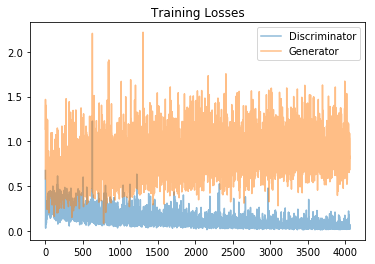

In [136]:
fig, ax = plt.subplots()
losses2 = np.array(losses2)
plt.plot(losses2.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses2.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [137]:
# Load samples from generator, taken while training
with open(save_file_name2, 'rb') as f:
    samples_config2 = pkl.load(f)

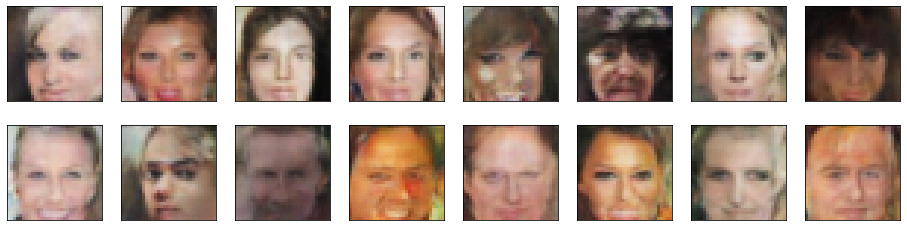

In [138]:
_ = view_samples(-1, samples_config2)

## Configuration 3: Changing Hyperparameters - epochs = 30

In [141]:
# Define model hyperparams
d_conv_dim3 = 32
g_conv_dim3 = 32
z_size3 = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D3, G3 = build_network(d_conv_dim3, g_conv_dim3, z_size3)
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')
    D3 = D3.cuda()
    G3 = G3.cuda()

# reducing by order 10 the lr
lr3 = 0.00002
beta1 = 0.5
beta2 = 0.999
d_optimizer3 = optim.Adam(D3.parameters(), lr3, [beta1, beta2])
g_optimizer3 = optim.Adam(G3.parameters(), lr3, [beta1, beta2])

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

In [142]:
# set number of epochs 
import time
n_epochs3 = 30
save_file_name3 = "train_samples3.pkl"

# call training function
start = time.time()
losses3 = train(D3, G3, n_epochs3, save_file_name3, z_size3, d_optimizer3, g_optimizer3, print_every=50)
end = time.time()
elapsed_time = end - start
print("elapsed_time: {} min, {} sec".format(elapsed_time//60, elapsed_time))

Epoch [    1/   30] | d_loss: 1.1617 | g_loss: 0.9755
Epoch [    1/   30] | d_loss: 0.2924 | g_loss: 0.5470
Epoch [    1/   30] | d_loss: 0.2035 | g_loss: 0.7902
Epoch [    1/   30] | d_loss: 0.0913 | g_loss: 0.8202
Epoch [    1/   30] | d_loss: 0.1789 | g_loss: 0.9490
Epoch [    1/   30] | d_loss: 0.0618 | g_loss: 0.9649
Epoch [    1/   30] | d_loss: 0.1013 | g_loss: 0.9454
Epoch [    1/   30] | d_loss: 0.1000 | g_loss: 0.8539
Epoch [    1/   30] | d_loss: 0.0981 | g_loss: 0.7717
Epoch [    1/   30] | d_loss: 0.0465 | g_loss: 1.0458
Epoch [    1/   30] | d_loss: 0.0852 | g_loss: 0.9954
Epoch [    1/   30] | d_loss: 0.0815 | g_loss: 0.9936
Epoch [    1/   30] | d_loss: 0.0883 | g_loss: 0.6576
Epoch [    1/   30] | d_loss: 0.0507 | g_loss: 0.9612
Epoch [    1/   30] | d_loss: 0.0761 | g_loss: 0.9655
Epoch [    1/   30] | d_loss: 0.0490 | g_loss: 0.8539
Epoch [    1/   30] | d_loss: 0.0838 | g_loss: 0.8882
Epoch [    1/   30] | d_loss: 0.0539 | g_loss: 0.9633
Epoch [    1/   30] | d_loss

Epoch [    3/   30] | d_loss: 0.2076 | g_loss: 0.4814
Epoch [    3/   30] | d_loss: 0.2486 | g_loss: 0.4950
Epoch [    3/   30] | d_loss: 0.2093 | g_loss: 0.4595
Epoch [    3/   30] | d_loss: 0.2718 | g_loss: 0.5629
Epoch [    3/   30] | d_loss: 0.2084 | g_loss: 0.4193
Epoch [    3/   30] | d_loss: 0.1873 | g_loss: 0.4870
Epoch [    3/   30] | d_loss: 0.3302 | g_loss: 0.5449
Epoch [    3/   30] | d_loss: 0.0952 | g_loss: 0.5189
Epoch [    3/   30] | d_loss: 0.1970 | g_loss: 0.7488
Epoch [    3/   30] | d_loss: 0.3086 | g_loss: 0.6569
Epoch [    3/   30] | d_loss: 0.2809 | g_loss: 0.5091
Epoch [    3/   30] | d_loss: 0.1484 | g_loss: 0.6204
Epoch [    3/   30] | d_loss: 0.3640 | g_loss: 0.4985
Epoch [    3/   30] | d_loss: 0.2849 | g_loss: 0.4546
Epoch [    3/   30] | d_loss: 0.2983 | g_loss: 0.6886
Epoch [    3/   30] | d_loss: 0.1400 | g_loss: 0.6498
Epoch [    3/   30] | d_loss: 0.1855 | g_loss: 0.6059
Epoch [    3/   30] | d_loss: 0.3226 | g_loss: 0.5565
Epoch [    3/   30] | d_loss

Epoch [    6/   30] | d_loss: 0.4272 | g_loss: 0.3850
Epoch [    6/   30] | d_loss: 0.2767 | g_loss: 0.3926
Epoch [    6/   30] | d_loss: 0.3200 | g_loss: 0.3343
Epoch [    6/   30] | d_loss: 0.4525 | g_loss: 0.3493
Epoch [    6/   30] | d_loss: 0.4369 | g_loss: 0.4407
Epoch [    6/   30] | d_loss: 0.2214 | g_loss: 0.5851
Epoch [    6/   30] | d_loss: 0.3842 | g_loss: 0.4968
Epoch [    6/   30] | d_loss: 0.4276 | g_loss: 0.4437
Epoch [    6/   30] | d_loss: 0.3533 | g_loss: 0.2794
Epoch [    6/   30] | d_loss: 0.3129 | g_loss: 0.4197
Epoch [    6/   30] | d_loss: 0.2926 | g_loss: 0.5359
Epoch [    6/   30] | d_loss: 0.4998 | g_loss: 0.4637
Epoch [    6/   30] | d_loss: 0.4206 | g_loss: 0.3162
Epoch [    6/   30] | d_loss: 0.3576 | g_loss: 0.4126
Epoch [    6/   30] | d_loss: 0.3118 | g_loss: 0.4203
Epoch [    6/   30] | d_loss: 0.4300 | g_loss: 0.4508
Epoch [    6/   30] | d_loss: 0.3382 | g_loss: 0.4116
Epoch [    6/   30] | d_loss: 0.2684 | g_loss: 0.3706
Epoch [    6/   30] | d_loss

Epoch [    8/   30] | d_loss: 0.2645 | g_loss: 0.3588
Epoch [    8/   30] | d_loss: 0.3901 | g_loss: 0.2823
Epoch [    8/   30] | d_loss: 0.3738 | g_loss: 0.5495
Epoch [    8/   30] | d_loss: 0.3372 | g_loss: 0.4300
Epoch [    8/   30] | d_loss: 0.3116 | g_loss: 0.5423
Epoch [    8/   30] | d_loss: 0.3217 | g_loss: 0.4821
Epoch [    8/   30] | d_loss: 0.2355 | g_loss: 0.6549
Epoch [    8/   30] | d_loss: 0.2403 | g_loss: 0.4487
Epoch [    9/   30] | d_loss: 0.2396 | g_loss: 0.3614
Epoch [    9/   30] | d_loss: 0.4012 | g_loss: 0.4239
Epoch [    9/   30] | d_loss: 0.2183 | g_loss: 0.2037
Epoch [    9/   30] | d_loss: 0.2184 | g_loss: 0.4942
Epoch [    9/   30] | d_loss: 0.5860 | g_loss: 0.3502
Epoch [    9/   30] | d_loss: 0.2640 | g_loss: 0.3855
Epoch [    9/   30] | d_loss: 0.3571 | g_loss: 0.3785
Epoch [    9/   30] | d_loss: 0.1512 | g_loss: 0.5040
Epoch [    9/   30] | d_loss: 0.4582 | g_loss: 0.6078
Epoch [    9/   30] | d_loss: 0.5486 | g_loss: 0.4060
Epoch [    9/   30] | d_loss

Epoch [   11/   30] | d_loss: 0.2170 | g_loss: 0.3654
Epoch [   11/   30] | d_loss: 0.3782 | g_loss: 0.3455
Epoch [   11/   30] | d_loss: 0.3274 | g_loss: 0.4324
Epoch [   11/   30] | d_loss: 0.3697 | g_loss: 0.5692
Epoch [   11/   30] | d_loss: 0.3250 | g_loss: 0.4968
Epoch [   11/   30] | d_loss: 0.3671 | g_loss: 0.5781
Epoch [   11/   30] | d_loss: 0.2950 | g_loss: 0.5663
Epoch [   11/   30] | d_loss: 0.4138 | g_loss: 0.3089
Epoch [   11/   30] | d_loss: 0.2542 | g_loss: 0.4526
Epoch [   11/   30] | d_loss: 0.1951 | g_loss: 0.7359
Epoch [   11/   30] | d_loss: 0.1767 | g_loss: 0.3868
Epoch [   11/   30] | d_loss: 0.3218 | g_loss: 0.2921
Epoch [   11/   30] | d_loss: 0.3153 | g_loss: 0.3651
Epoch [   11/   30] | d_loss: 0.2981 | g_loss: 0.2875
Epoch [   11/   30] | d_loss: 0.4012 | g_loss: 0.4577
Epoch [   11/   30] | d_loss: 0.5522 | g_loss: 0.4970
Epoch [   11/   30] | d_loss: 0.2537 | g_loss: 0.5867
Epoch [   11/   30] | d_loss: 0.3865 | g_loss: 0.4583
Epoch [   11/   30] | d_loss

Epoch [   14/   30] | d_loss: 0.2195 | g_loss: 0.3617
Epoch [   14/   30] | d_loss: 0.3183 | g_loss: 0.4995
Epoch [   14/   30] | d_loss: 0.2485 | g_loss: 0.5404
Epoch [   14/   30] | d_loss: 0.1497 | g_loss: 0.4469
Epoch [   14/   30] | d_loss: 0.4660 | g_loss: 0.6043
Epoch [   14/   30] | d_loss: 0.0942 | g_loss: 0.5514
Epoch [   14/   30] | d_loss: 0.0933 | g_loss: 0.6893
Epoch [   14/   30] | d_loss: 0.3333 | g_loss: 0.4521
Epoch [   14/   30] | d_loss: 0.4343 | g_loss: 0.4318
Epoch [   14/   30] | d_loss: 0.3011 | g_loss: 0.5205
Epoch [   14/   30] | d_loss: 0.2227 | g_loss: 0.6670
Epoch [   14/   30] | d_loss: 0.2432 | g_loss: 0.4021
Epoch [   14/   30] | d_loss: 0.2035 | g_loss: 0.5602
Epoch [   14/   30] | d_loss: 0.1781 | g_loss: 0.4534
Epoch [   14/   30] | d_loss: 0.1568 | g_loss: 0.5767
Epoch [   14/   30] | d_loss: 0.2784 | g_loss: 0.3626
Epoch [   14/   30] | d_loss: 0.3012 | g_loss: 0.3996
Epoch [   14/   30] | d_loss: 0.3778 | g_loss: 0.5672
Epoch [   14/   30] | d_loss

Epoch [   16/   30] | d_loss: 0.2515 | g_loss: 0.9772
Epoch [   16/   30] | d_loss: 0.2417 | g_loss: 0.7474
Epoch [   16/   30] | d_loss: 0.1764 | g_loss: 0.4111
Epoch [   16/   30] | d_loss: 0.2641 | g_loss: 0.4138
Epoch [   16/   30] | d_loss: 0.3955 | g_loss: 0.4574
Epoch [   16/   30] | d_loss: 0.1318 | g_loss: 0.6357
Epoch [   16/   30] | d_loss: 0.2494 | g_loss: 0.3613
Epoch [   16/   30] | d_loss: 0.2664 | g_loss: 0.4937
Epoch [   16/   30] | d_loss: 0.2404 | g_loss: 0.5894
Epoch [   16/   30] | d_loss: 0.3817 | g_loss: 0.3495
Epoch [   16/   30] | d_loss: 0.3456 | g_loss: 0.5177
Epoch [   16/   30] | d_loss: 0.2572 | g_loss: 0.4947
Epoch [   16/   30] | d_loss: 0.4362 | g_loss: 0.5197
Epoch [   16/   30] | d_loss: 0.3246 | g_loss: 0.4034
Epoch [   16/   30] | d_loss: 0.3512 | g_loss: 0.4245
Epoch [   16/   30] | d_loss: 0.1951 | g_loss: 0.6764
Epoch [   17/   30] | d_loss: 0.4062 | g_loss: 0.3849
Epoch [   17/   30] | d_loss: 0.1618 | g_loss: 0.3575
Epoch [   17/   30] | d_loss

Epoch [   19/   30] | d_loss: 0.3921 | g_loss: 0.4379
Epoch [   19/   30] | d_loss: 0.2497 | g_loss: 0.4587
Epoch [   19/   30] | d_loss: 0.2300 | g_loss: 0.2962
Epoch [   19/   30] | d_loss: 0.4889 | g_loss: 0.5551
Epoch [   19/   30] | d_loss: 0.1981 | g_loss: 0.5795
Epoch [   19/   30] | d_loss: 0.2444 | g_loss: 0.5909
Epoch [   19/   30] | d_loss: 0.1652 | g_loss: 0.5175
Epoch [   19/   30] | d_loss: 0.2874 | g_loss: 0.6410
Epoch [   19/   30] | d_loss: 0.2489 | g_loss: 0.3333
Epoch [   19/   30] | d_loss: 0.3831 | g_loss: 0.3051
Epoch [   19/   30] | d_loss: 0.1410 | g_loss: 0.4808
Epoch [   19/   30] | d_loss: 0.2673 | g_loss: 0.5635
Epoch [   19/   30] | d_loss: 0.2940 | g_loss: 0.3520
Epoch [   19/   30] | d_loss: 0.2304 | g_loss: 0.5716
Epoch [   19/   30] | d_loss: 0.1475 | g_loss: 0.4815
Epoch [   19/   30] | d_loss: 0.2675 | g_loss: 0.3273
Epoch [   19/   30] | d_loss: 0.2003 | g_loss: 0.5283
Epoch [   19/   30] | d_loss: 0.4222 | g_loss: 0.3607
Epoch [   19/   30] | d_loss

Epoch [   21/   30] | d_loss: 0.1554 | g_loss: 0.8062
Epoch [   21/   30] | d_loss: 0.2540 | g_loss: 0.4571
Epoch [   22/   30] | d_loss: 0.3170 | g_loss: 0.5049
Epoch [   22/   30] | d_loss: 0.2486 | g_loss: 0.5290
Epoch [   22/   30] | d_loss: 0.2427 | g_loss: 0.3374
Epoch [   22/   30] | d_loss: 0.2452 | g_loss: 0.3814
Epoch [   22/   30] | d_loss: 0.2662 | g_loss: 0.4915
Epoch [   22/   30] | d_loss: 0.1957 | g_loss: 0.6544
Epoch [   22/   30] | d_loss: 0.2928 | g_loss: 0.4739
Epoch [   22/   30] | d_loss: 0.3038 | g_loss: 0.3442
Epoch [   22/   30] | d_loss: 0.3042 | g_loss: 0.3846
Epoch [   22/   30] | d_loss: 0.1983 | g_loss: 0.4923
Epoch [   22/   30] | d_loss: 0.2108 | g_loss: 0.7138
Epoch [   22/   30] | d_loss: 0.1556 | g_loss: 0.5187
Epoch [   22/   30] | d_loss: 0.3315 | g_loss: 0.5076
Epoch [   22/   30] | d_loss: 0.2198 | g_loss: 0.3427
Epoch [   22/   30] | d_loss: 0.2254 | g_loss: 0.4770
Epoch [   22/   30] | d_loss: 0.2107 | g_loss: 0.7353
Epoch [   22/   30] | d_loss

Epoch [   24/   30] | d_loss: 0.1598 | g_loss: 0.4405
Epoch [   24/   30] | d_loss: 0.2092 | g_loss: 0.6073
Epoch [   24/   30] | d_loss: 0.3039 | g_loss: 0.3417
Epoch [   24/   30] | d_loss: 0.3383 | g_loss: 0.6328
Epoch [   24/   30] | d_loss: 0.4045 | g_loss: 0.4775
Epoch [   24/   30] | d_loss: 0.1300 | g_loss: 0.4671
Epoch [   24/   30] | d_loss: 0.2968 | g_loss: 0.5077
Epoch [   24/   30] | d_loss: 0.3774 | g_loss: 0.3296
Epoch [   24/   30] | d_loss: 0.4715 | g_loss: 0.3274
Epoch [   24/   30] | d_loss: 0.2890 | g_loss: 0.5626
Epoch [   24/   30] | d_loss: 0.3676 | g_loss: 0.3877
Epoch [   24/   30] | d_loss: 0.1713 | g_loss: 0.4792
Epoch [   24/   30] | d_loss: 0.4263 | g_loss: 0.3470
Epoch [   24/   30] | d_loss: 0.2408 | g_loss: 0.6626
Epoch [   24/   30] | d_loss: 0.3545 | g_loss: 0.6684
Epoch [   24/   30] | d_loss: 0.4020 | g_loss: 0.4168
Epoch [   24/   30] | d_loss: 0.3277 | g_loss: 0.6673
Epoch [   24/   30] | d_loss: 0.1201 | g_loss: 0.7164
Epoch [   24/   30] | d_loss

Epoch [   27/   30] | d_loss: 0.3779 | g_loss: 0.3500
Epoch [   27/   30] | d_loss: 0.2055 | g_loss: 0.5064
Epoch [   27/   30] | d_loss: 0.2397 | g_loss: 0.6735
Epoch [   27/   30] | d_loss: 0.3024 | g_loss: 0.6246
Epoch [   27/   30] | d_loss: 0.1374 | g_loss: 0.5741
Epoch [   27/   30] | d_loss: 0.1302 | g_loss: 0.9145
Epoch [   27/   30] | d_loss: 0.3636 | g_loss: 0.5310
Epoch [   27/   30] | d_loss: 0.3587 | g_loss: 0.5732
Epoch [   27/   30] | d_loss: 0.3664 | g_loss: 0.2701
Epoch [   27/   30] | d_loss: 0.2362 | g_loss: 0.6227
Epoch [   27/   30] | d_loss: 0.1432 | g_loss: 0.7798
Epoch [   27/   30] | d_loss: 0.1828 | g_loss: 0.4730
Epoch [   27/   30] | d_loss: 0.3465 | g_loss: 0.3196
Epoch [   27/   30] | d_loss: 0.4341 | g_loss: 0.4917
Epoch [   27/   30] | d_loss: 0.0808 | g_loss: 0.4597
Epoch [   27/   30] | d_loss: 0.4495 | g_loss: 0.3220
Epoch [   27/   30] | d_loss: 0.1422 | g_loss: 0.5706
Epoch [   27/   30] | d_loss: 0.1390 | g_loss: 0.7092
Epoch [   27/   30] | d_loss

Epoch [   29/   30] | d_loss: 0.2746 | g_loss: 0.7149
Epoch [   29/   30] | d_loss: 0.1668 | g_loss: 0.8328
Epoch [   29/   30] | d_loss: 0.1362 | g_loss: 0.5639
Epoch [   29/   30] | d_loss: 0.2225 | g_loss: 0.3284
Epoch [   29/   30] | d_loss: 0.2143 | g_loss: 0.4558
Epoch [   29/   30] | d_loss: 0.2732 | g_loss: 0.4620
Epoch [   29/   30] | d_loss: 0.1057 | g_loss: 0.7889
Epoch [   29/   30] | d_loss: 0.2246 | g_loss: 0.3814
Epoch [   29/   30] | d_loss: 0.1558 | g_loss: 0.7757
Epoch [   29/   30] | d_loss: 0.2111 | g_loss: 0.6332
Epoch [   30/   30] | d_loss: 0.1884 | g_loss: 0.6174
Epoch [   30/   30] | d_loss: 0.3249 | g_loss: 0.5588
Epoch [   30/   30] | d_loss: 0.2184 | g_loss: 0.2949
Epoch [   30/   30] | d_loss: 0.2807 | g_loss: 0.3643
Epoch [   30/   30] | d_loss: 0.4123 | g_loss: 0.3884
Epoch [   30/   30] | d_loss: 0.1498 | g_loss: 0.8602
Epoch [   30/   30] | d_loss: 0.3487 | g_loss: 0.6173
Epoch [   30/   30] | d_loss: 0.2502 | g_loss: 0.6260
Epoch [   30/   30] | d_loss

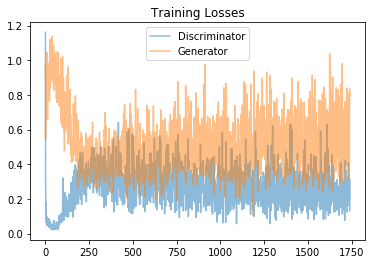

In [143]:
fig, ax = plt.subplots()
losses3 = np.array(losses3)
plt.plot(losses3.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses3.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [146]:
# Load samples from generator, taken while training
with open(save_file_name3, 'rb') as f:
    samples_config3 = pkl.load(f)

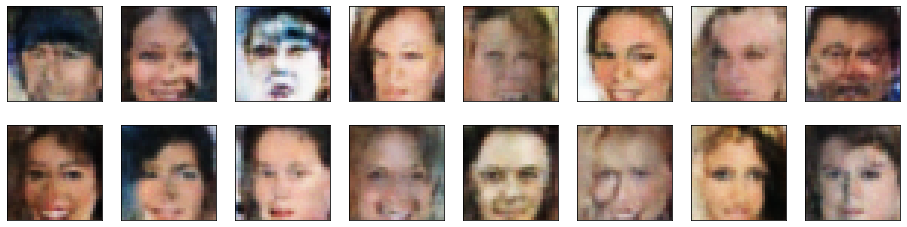

In [147]:
_ = view_samples(-1, samples_config3)

## Configuration 4: Changing Hyperparameters - epochs = 50

Confirming that the default configuration gets better results.

In [150]:
# Define model hyperparams
d_conv_dim4 = 32
g_conv_dim4 = 32
z_size4 = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D4, G4 = build_network(d_conv_dim4, g_conv_dim4, z_size4)

# reducing by order 10 the lr
lr4 = 0.000002
beta1 = 0.5
beta2 = 0.999
d_optimizer4 = optim.Adam(D4.parameters(), lr4, [beta1, beta2])
g_optimizer4 = optim.Adam(G4.parameters(), lr4, [beta1, beta2])

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

In [151]:
# set number of epochs 
import time
n_epochs4 = 50
save_file_name4 = "train_samples4.pkl"

# call training function
start = time.time()
losses4 = train(D4, G4, n_epochs4, save_file_name4, z_size4, d_optimizer4, g_optimizer4, print_every=50)
end = time.time()
elapsed_time = end - start
print("elapsed_time: {} min, {} sec".format(elapsed_time//60, elapsed_time))

Epoch [    1/   50] | d_loss: 0.6811 | g_loss: 1.4844
Epoch [    1/   50] | d_loss: 0.3242 | g_loss: 1.0905
Epoch [    1/   50] | d_loss: 0.4230 | g_loss: 0.7802
Epoch [    1/   50] | d_loss: 0.4145 | g_loss: 1.0614
Epoch [    1/   50] | d_loss: 0.3729 | g_loss: 0.9758
Epoch [    1/   50] | d_loss: 0.2214 | g_loss: 0.8824
Epoch [    1/   50] | d_loss: 0.1951 | g_loss: 0.6228
Epoch [    1/   50] | d_loss: 0.2655 | g_loss: 0.7591
Epoch [    1/   50] | d_loss: 0.2260 | g_loss: 0.8086
Epoch [    1/   50] | d_loss: 0.1238 | g_loss: 1.0878
Epoch [    1/   50] | d_loss: 0.2019 | g_loss: 1.1316
Epoch [    1/   50] | d_loss: 0.1587 | g_loss: 0.8562
Epoch [    1/   50] | d_loss: 0.1105 | g_loss: 0.9402
Epoch [    1/   50] | d_loss: 0.2578 | g_loss: 0.9470
Epoch [    1/   50] | d_loss: 0.1787 | g_loss: 0.8958
Epoch [    1/   50] | d_loss: 0.1930 | g_loss: 0.8577
Epoch [    1/   50] | d_loss: 0.1609 | g_loss: 1.0544
Epoch [    1/   50] | d_loss: 0.1514 | g_loss: 0.7770
Epoch [    1/   50] | d_loss

Epoch [    3/   50] | d_loss: 0.0384 | g_loss: 0.9997
Epoch [    3/   50] | d_loss: 0.0475 | g_loss: 0.9743
Epoch [    3/   50] | d_loss: 0.0449 | g_loss: 0.8831
Epoch [    3/   50] | d_loss: 0.0530 | g_loss: 0.8454
Epoch [    3/   50] | d_loss: 0.0350 | g_loss: 1.0057
Epoch [    3/   50] | d_loss: 0.0477 | g_loss: 0.9780
Epoch [    3/   50] | d_loss: 0.0511 | g_loss: 0.9093
Epoch [    3/   50] | d_loss: 0.0516 | g_loss: 0.9080
Epoch [    3/   50] | d_loss: 0.0404 | g_loss: 1.0925
Epoch [    3/   50] | d_loss: 0.0466 | g_loss: 0.9836
Epoch [    3/   50] | d_loss: 0.0512 | g_loss: 1.0084
Epoch [    3/   50] | d_loss: 0.0397 | g_loss: 0.8890
Epoch [    3/   50] | d_loss: 0.0456 | g_loss: 1.1236
Epoch [    3/   50] | d_loss: 0.0405 | g_loss: 0.8142
Epoch [    3/   50] | d_loss: 0.0437 | g_loss: 0.8963
Epoch [    3/   50] | d_loss: 0.0421 | g_loss: 0.9242
Epoch [    3/   50] | d_loss: 0.0459 | g_loss: 0.9099
Epoch [    3/   50] | d_loss: 0.0317 | g_loss: 0.8534
Epoch [    3/   50] | d_loss

Epoch [    6/   50] | d_loss: 0.0204 | g_loss: 1.1162
Epoch [    6/   50] | d_loss: 0.0202 | g_loss: 0.8876
Epoch [    6/   50] | d_loss: 0.0223 | g_loss: 0.8881
Epoch [    6/   50] | d_loss: 0.0390 | g_loss: 0.9291
Epoch [    6/   50] | d_loss: 0.0245 | g_loss: 0.9838
Epoch [    6/   50] | d_loss: 0.0281 | g_loss: 0.9657
Epoch [    6/   50] | d_loss: 0.0140 | g_loss: 0.9502
Epoch [    6/   50] | d_loss: 0.0258 | g_loss: 0.9724
Epoch [    6/   50] | d_loss: 0.0344 | g_loss: 1.0301
Epoch [    6/   50] | d_loss: 0.0217 | g_loss: 1.0115
Epoch [    6/   50] | d_loss: 0.0452 | g_loss: 1.0432
Epoch [    6/   50] | d_loss: 0.0336 | g_loss: 1.0593
Epoch [    6/   50] | d_loss: 0.0396 | g_loss: 0.9440
Epoch [    6/   50] | d_loss: 0.0160 | g_loss: 0.8341
Epoch [    6/   50] | d_loss: 0.0385 | g_loss: 1.0207
Epoch [    6/   50] | d_loss: 0.0255 | g_loss: 0.9965
Epoch [    6/   50] | d_loss: 0.0228 | g_loss: 1.0096
Epoch [    6/   50] | d_loss: 0.0405 | g_loss: 1.0593
Epoch [    6/   50] | d_loss

Epoch [    8/   50] | d_loss: 0.0141 | g_loss: 0.8868
Epoch [    8/   50] | d_loss: 0.0219 | g_loss: 0.8738
Epoch [    8/   50] | d_loss: 0.0508 | g_loss: 0.8599
Epoch [    8/   50] | d_loss: 0.0324 | g_loss: 1.0065
Epoch [    8/   50] | d_loss: 0.0398 | g_loss: 0.8667
Epoch [    8/   50] | d_loss: 0.0196 | g_loss: 0.7524
Epoch [    8/   50] | d_loss: 0.0439 | g_loss: 0.9074
Epoch [    8/   50] | d_loss: 0.0267 | g_loss: 0.9138
Epoch [    9/   50] | d_loss: 0.0784 | g_loss: 0.9259
Epoch [    9/   50] | d_loss: 0.0381 | g_loss: 0.8680
Epoch [    9/   50] | d_loss: 0.0189 | g_loss: 0.8396
Epoch [    9/   50] | d_loss: 0.0221 | g_loss: 1.0123
Epoch [    9/   50] | d_loss: 0.0206 | g_loss: 0.8704
Epoch [    9/   50] | d_loss: 0.0309 | g_loss: 0.9194
Epoch [    9/   50] | d_loss: 0.0349 | g_loss: 0.9629
Epoch [    9/   50] | d_loss: 0.0241 | g_loss: 0.9515
Epoch [    9/   50] | d_loss: 0.0216 | g_loss: 0.9557
Epoch [    9/   50] | d_loss: 0.0272 | g_loss: 0.8884
Epoch [    9/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.0527 | g_loss: 0.9015
Epoch [   11/   50] | d_loss: 0.0801 | g_loss: 0.9173
Epoch [   11/   50] | d_loss: 0.0602 | g_loss: 0.9976
Epoch [   11/   50] | d_loss: 0.0497 | g_loss: 0.8639
Epoch [   11/   50] | d_loss: 0.0381 | g_loss: 0.8420
Epoch [   11/   50] | d_loss: 0.0290 | g_loss: 0.8435
Epoch [   11/   50] | d_loss: 0.0591 | g_loss: 0.7685
Epoch [   11/   50] | d_loss: 0.0775 | g_loss: 0.8448
Epoch [   11/   50] | d_loss: 0.0418 | g_loss: 0.7458
Epoch [   11/   50] | d_loss: 0.0268 | g_loss: 1.0104
Epoch [   11/   50] | d_loss: 0.1030 | g_loss: 0.8147
Epoch [   11/   50] | d_loss: 0.0434 | g_loss: 0.8639
Epoch [   11/   50] | d_loss: 0.0326 | g_loss: 0.9407
Epoch [   11/   50] | d_loss: 0.1011 | g_loss: 0.8587
Epoch [   11/   50] | d_loss: 0.0735 | g_loss: 0.8781
Epoch [   11/   50] | d_loss: 0.0556 | g_loss: 0.9342
Epoch [   11/   50] | d_loss: 0.0380 | g_loss: 0.9912
Epoch [   11/   50] | d_loss: 0.0249 | g_loss: 0.9079
Epoch [   11/   50] | d_loss

Epoch [   14/   50] | d_loss: 0.0449 | g_loss: 0.7907
Epoch [   14/   50] | d_loss: 0.0738 | g_loss: 0.8627
Epoch [   14/   50] | d_loss: 0.0942 | g_loss: 0.7464
Epoch [   14/   50] | d_loss: 0.0815 | g_loss: 0.7988
Epoch [   14/   50] | d_loss: 0.0700 | g_loss: 0.8272
Epoch [   14/   50] | d_loss: 0.0379 | g_loss: 0.8546
Epoch [   14/   50] | d_loss: 0.0519 | g_loss: 0.7748
Epoch [   14/   50] | d_loss: 0.1117 | g_loss: 0.8155
Epoch [   14/   50] | d_loss: 0.0592 | g_loss: 0.7898
Epoch [   14/   50] | d_loss: 0.0697 | g_loss: 0.9208
Epoch [   14/   50] | d_loss: 0.1400 | g_loss: 0.8052
Epoch [   14/   50] | d_loss: 0.1824 | g_loss: 0.8569
Epoch [   14/   50] | d_loss: 0.0905 | g_loss: 0.7636
Epoch [   14/   50] | d_loss: 0.0916 | g_loss: 0.8488
Epoch [   14/   50] | d_loss: 0.1094 | g_loss: 0.6258
Epoch [   14/   50] | d_loss: 0.0435 | g_loss: 0.9128
Epoch [   14/   50] | d_loss: 0.0978 | g_loss: 0.8017
Epoch [   14/   50] | d_loss: 0.1148 | g_loss: 0.6596
Epoch [   14/   50] | d_loss

Epoch [   16/   50] | d_loss: 0.1084 | g_loss: 0.7784
Epoch [   16/   50] | d_loss: 0.1366 | g_loss: 0.7850
Epoch [   16/   50] | d_loss: 0.0650 | g_loss: 0.7417
Epoch [   16/   50] | d_loss: 0.1446 | g_loss: 0.8544
Epoch [   16/   50] | d_loss: 0.1579 | g_loss: 0.6238
Epoch [   16/   50] | d_loss: 0.1606 | g_loss: 0.7568
Epoch [   16/   50] | d_loss: 0.1021 | g_loss: 0.7098
Epoch [   16/   50] | d_loss: 0.1632 | g_loss: 0.7311
Epoch [   16/   50] | d_loss: 0.0872 | g_loss: 0.7879
Epoch [   16/   50] | d_loss: 0.0698 | g_loss: 0.8597
Epoch [   16/   50] | d_loss: 0.0681 | g_loss: 0.7753
Epoch [   16/   50] | d_loss: 0.0881 | g_loss: 0.6086
Epoch [   16/   50] | d_loss: 0.1000 | g_loss: 0.5912
Epoch [   16/   50] | d_loss: 0.1261 | g_loss: 0.8555
Epoch [   16/   50] | d_loss: 0.1681 | g_loss: 0.6211
Epoch [   16/   50] | d_loss: 0.1452 | g_loss: 0.6978
Epoch [   17/   50] | d_loss: 0.1104 | g_loss: 0.7940
Epoch [   17/   50] | d_loss: 0.1808 | g_loss: 0.7094
Epoch [   17/   50] | d_loss

Epoch [   19/   50] | d_loss: 0.1244 | g_loss: 0.7225
Epoch [   19/   50] | d_loss: 0.1085 | g_loss: 0.6867
Epoch [   19/   50] | d_loss: 0.1134 | g_loss: 0.7491
Epoch [   19/   50] | d_loss: 0.1153 | g_loss: 0.6988
Epoch [   19/   50] | d_loss: 0.0623 | g_loss: 0.6776
Epoch [   19/   50] | d_loss: 0.1643 | g_loss: 0.7545
Epoch [   19/   50] | d_loss: 0.0772 | g_loss: 0.8069
Epoch [   19/   50] | d_loss: 0.1050 | g_loss: 0.7254
Epoch [   19/   50] | d_loss: 0.0817 | g_loss: 0.8067
Epoch [   19/   50] | d_loss: 0.0783 | g_loss: 0.8046
Epoch [   19/   50] | d_loss: 0.1210 | g_loss: 0.7515
Epoch [   19/   50] | d_loss: 0.0905 | g_loss: 0.7834
Epoch [   19/   50] | d_loss: 0.0660 | g_loss: 0.6916
Epoch [   19/   50] | d_loss: 0.0869 | g_loss: 0.8064
Epoch [   19/   50] | d_loss: 0.1307 | g_loss: 0.6308
Epoch [   19/   50] | d_loss: 0.1053 | g_loss: 0.7259
Epoch [   19/   50] | d_loss: 0.1188 | g_loss: 0.7129
Epoch [   19/   50] | d_loss: 0.1222 | g_loss: 0.6726
Epoch [   19/   50] | d_loss

Epoch [   21/   50] | d_loss: 0.1258 | g_loss: 0.7354
Epoch [   21/   50] | d_loss: 0.1505 | g_loss: 0.7148
Epoch [   22/   50] | d_loss: 0.0819 | g_loss: 0.7735
Epoch [   22/   50] | d_loss: 0.1403 | g_loss: 0.6099
Epoch [   22/   50] | d_loss: 0.1069 | g_loss: 0.6325
Epoch [   22/   50] | d_loss: 0.2002 | g_loss: 0.6347
Epoch [   22/   50] | d_loss: 0.1459 | g_loss: 0.6856
Epoch [   22/   50] | d_loss: 0.1234 | g_loss: 0.7639
Epoch [   22/   50] | d_loss: 0.1202 | g_loss: 0.8452
Epoch [   22/   50] | d_loss: 0.2348 | g_loss: 0.6638
Epoch [   22/   50] | d_loss: 0.1560 | g_loss: 0.7740
Epoch [   22/   50] | d_loss: 0.1892 | g_loss: 0.7524
Epoch [   22/   50] | d_loss: 0.0793 | g_loss: 0.6140
Epoch [   22/   50] | d_loss: 0.1690 | g_loss: 0.5384
Epoch [   22/   50] | d_loss: 0.1117 | g_loss: 0.7886
Epoch [   22/   50] | d_loss: 0.1530 | g_loss: 0.6381
Epoch [   22/   50] | d_loss: 0.1688 | g_loss: 0.7289
Epoch [   22/   50] | d_loss: 0.2159 | g_loss: 0.7085
Epoch [   22/   50] | d_loss

Epoch [   24/   50] | d_loss: 0.1520 | g_loss: 0.8087
Epoch [   24/   50] | d_loss: 0.2311 | g_loss: 0.5755
Epoch [   24/   50] | d_loss: 0.0863 | g_loss: 0.6479
Epoch [   24/   50] | d_loss: 0.0906 | g_loss: 0.7562
Epoch [   24/   50] | d_loss: 0.0951 | g_loss: 0.7253
Epoch [   24/   50] | d_loss: 0.1456 | g_loss: 0.3483
Epoch [   24/   50] | d_loss: 0.1326 | g_loss: 0.5616
Epoch [   24/   50] | d_loss: 0.0723 | g_loss: 0.9087
Epoch [   24/   50] | d_loss: 0.0920 | g_loss: 0.6284
Epoch [   24/   50] | d_loss: 0.1577 | g_loss: 0.6456
Epoch [   24/   50] | d_loss: 0.1527 | g_loss: 0.6934
Epoch [   24/   50] | d_loss: 0.1806 | g_loss: 0.8674
Epoch [   24/   50] | d_loss: 0.1167 | g_loss: 0.7473
Epoch [   24/   50] | d_loss: 0.2747 | g_loss: 0.8550
Epoch [   24/   50] | d_loss: 0.0865 | g_loss: 0.6687
Epoch [   24/   50] | d_loss: 0.2013 | g_loss: 0.8194
Epoch [   24/   50] | d_loss: 0.1107 | g_loss: 0.7846
Epoch [   24/   50] | d_loss: 0.1982 | g_loss: 0.7732
Epoch [   24/   50] | d_loss

Epoch [   27/   50] | d_loss: 0.2927 | g_loss: 0.6089
Epoch [   27/   50] | d_loss: 0.1892 | g_loss: 0.5814
Epoch [   27/   50] | d_loss: 0.2069 | g_loss: 0.4740
Epoch [   27/   50] | d_loss: 0.1233 | g_loss: 0.6304
Epoch [   27/   50] | d_loss: 0.1267 | g_loss: 0.5897
Epoch [   27/   50] | d_loss: 0.1965 | g_loss: 0.6308
Epoch [   27/   50] | d_loss: 0.0918 | g_loss: 0.5606
Epoch [   27/   50] | d_loss: 0.1669 | g_loss: 0.7144
Epoch [   27/   50] | d_loss: 0.1218 | g_loss: 0.5807
Epoch [   27/   50] | d_loss: 0.1064 | g_loss: 0.5702
Epoch [   27/   50] | d_loss: 0.2123 | g_loss: 0.6370
Epoch [   27/   50] | d_loss: 0.2810 | g_loss: 0.5808
Epoch [   27/   50] | d_loss: 0.1225 | g_loss: 0.6091
Epoch [   27/   50] | d_loss: 0.2223 | g_loss: 0.5730
Epoch [   27/   50] | d_loss: 0.1654 | g_loss: 0.5724
Epoch [   27/   50] | d_loss: 0.2716 | g_loss: 0.6575
Epoch [   27/   50] | d_loss: 0.2356 | g_loss: 0.6620
Epoch [   27/   50] | d_loss: 0.2185 | g_loss: 0.6376
Epoch [   27/   50] | d_loss

Epoch [   29/   50] | d_loss: 0.2005 | g_loss: 0.5654
Epoch [   29/   50] | d_loss: 0.2030 | g_loss: 0.5917
Epoch [   29/   50] | d_loss: 0.2903 | g_loss: 0.5535
Epoch [   29/   50] | d_loss: 0.2496 | g_loss: 0.5524
Epoch [   29/   50] | d_loss: 0.2047 | g_loss: 0.4822
Epoch [   29/   50] | d_loss: 0.2704 | g_loss: 0.5617
Epoch [   29/   50] | d_loss: 0.1809 | g_loss: 0.4989
Epoch [   29/   50] | d_loss: 0.1753 | g_loss: 0.3853
Epoch [   29/   50] | d_loss: 0.2279 | g_loss: 0.4716
Epoch [   29/   50] | d_loss: 0.2892 | g_loss: 0.4239
Epoch [   30/   50] | d_loss: 0.2025 | g_loss: 0.6711
Epoch [   30/   50] | d_loss: 0.2705 | g_loss: 0.6129
Epoch [   30/   50] | d_loss: 0.2905 | g_loss: 0.4906
Epoch [   30/   50] | d_loss: 0.3256 | g_loss: 0.5159
Epoch [   30/   50] | d_loss: 0.2752 | g_loss: 0.5192
Epoch [   30/   50] | d_loss: 0.2554 | g_loss: 0.4639
Epoch [   30/   50] | d_loss: 0.3234 | g_loss: 0.5792
Epoch [   30/   50] | d_loss: 0.2235 | g_loss: 0.5163
Epoch [   30/   50] | d_loss

Epoch [   32/   50] | d_loss: 0.2836 | g_loss: 0.4889
Epoch [   32/   50] | d_loss: 0.2349 | g_loss: 0.4499
Epoch [   32/   50] | d_loss: 0.2582 | g_loss: 0.5258
Epoch [   32/   50] | d_loss: 0.3054 | g_loss: 0.3983
Epoch [   32/   50] | d_loss: 0.3342 | g_loss: 0.5327
Epoch [   32/   50] | d_loss: 0.2536 | g_loss: 0.4655
Epoch [   32/   50] | d_loss: 0.3513 | g_loss: 0.4771
Epoch [   32/   50] | d_loss: 0.2367 | g_loss: 0.5103
Epoch [   32/   50] | d_loss: 0.1928 | g_loss: 0.4996
Epoch [   32/   50] | d_loss: 0.3044 | g_loss: 0.4346
Epoch [   32/   50] | d_loss: 0.2747 | g_loss: 0.5480
Epoch [   32/   50] | d_loss: 0.2036 | g_loss: 0.5379
Epoch [   32/   50] | d_loss: 0.3017 | g_loss: 0.3937
Epoch [   32/   50] | d_loss: 0.2154 | g_loss: 0.6392
Epoch [   32/   50] | d_loss: 0.2110 | g_loss: 0.4885
Epoch [   32/   50] | d_loss: 0.2175 | g_loss: 0.5508
Epoch [   32/   50] | d_loss: 0.3518 | g_loss: 0.5776
Epoch [   32/   50] | d_loss: 0.2821 | g_loss: 0.4800
Epoch [   32/   50] | d_loss

Epoch [   35/   50] | d_loss: 0.2624 | g_loss: 0.5280
Epoch [   35/   50] | d_loss: 0.1846 | g_loss: 0.5548
Epoch [   35/   50] | d_loss: 0.2305 | g_loss: 0.4815
Epoch [   35/   50] | d_loss: 0.3148 | g_loss: 0.4308
Epoch [   35/   50] | d_loss: 0.4336 | g_loss: 0.4801
Epoch [   35/   50] | d_loss: 0.2149 | g_loss: 0.3981
Epoch [   35/   50] | d_loss: 0.2480 | g_loss: 0.5004
Epoch [   35/   50] | d_loss: 0.2988 | g_loss: 0.4906
Epoch [   35/   50] | d_loss: 0.3188 | g_loss: 0.4034
Epoch [   35/   50] | d_loss: 0.3493 | g_loss: 0.4308
Epoch [   35/   50] | d_loss: 0.3568 | g_loss: 0.4542
Epoch [   35/   50] | d_loss: 0.2749 | g_loss: 0.4839
Epoch [   35/   50] | d_loss: 0.3665 | g_loss: 0.5256
Epoch [   35/   50] | d_loss: 0.1984 | g_loss: 0.4892
Epoch [   35/   50] | d_loss: 0.4754 | g_loss: 0.5307
Epoch [   35/   50] | d_loss: 0.2198 | g_loss: 0.4076
Epoch [   35/   50] | d_loss: 0.2561 | g_loss: 0.4396
Epoch [   35/   50] | d_loss: 0.1355 | g_loss: 0.4379
Epoch [   35/   50] | d_loss

Epoch [   37/   50] | d_loss: 0.4033 | g_loss: 0.4537
Epoch [   37/   50] | d_loss: 0.2022 | g_loss: 0.4613
Epoch [   37/   50] | d_loss: 0.2202 | g_loss: 0.4247
Epoch [   37/   50] | d_loss: 0.3147 | g_loss: 0.5544
Epoch [   37/   50] | d_loss: 0.4037 | g_loss: 0.4222
Epoch [   37/   50] | d_loss: 0.2653 | g_loss: 0.4543
Epoch [   37/   50] | d_loss: 0.2915 | g_loss: 0.4405
Epoch [   37/   50] | d_loss: 0.2038 | g_loss: 0.4592
Epoch [   37/   50] | d_loss: 0.3359 | g_loss: 0.4889
Epoch [   37/   50] | d_loss: 0.4583 | g_loss: 0.5456
Epoch [   37/   50] | d_loss: 0.3356 | g_loss: 0.4719
Epoch [   37/   50] | d_loss: 0.2753 | g_loss: 0.4680
Epoch [   37/   50] | d_loss: 0.3275 | g_loss: 0.4557
Epoch [   37/   50] | d_loss: 0.3225 | g_loss: 0.3958
Epoch [   37/   50] | d_loss: 0.2629 | g_loss: 0.4491
Epoch [   37/   50] | d_loss: 0.2500 | g_loss: 0.4865
Epoch [   37/   50] | d_loss: 0.3128 | g_loss: 0.4138
Epoch [   37/   50] | d_loss: 0.2087 | g_loss: 0.4160
Epoch [   38/   50] | d_loss

Epoch [   40/   50] | d_loss: 0.3198 | g_loss: 0.5185
Epoch [   40/   50] | d_loss: 0.3460 | g_loss: 0.3736
Epoch [   40/   50] | d_loss: 0.3371 | g_loss: 0.4205
Epoch [   40/   50] | d_loss: 0.3032 | g_loss: 0.4183
Epoch [   40/   50] | d_loss: 0.3589 | g_loss: 0.4430
Epoch [   40/   50] | d_loss: 0.3023 | g_loss: 0.4271
Epoch [   40/   50] | d_loss: 0.2777 | g_loss: 0.4627
Epoch [   40/   50] | d_loss: 0.2767 | g_loss: 0.4910
Epoch [   40/   50] | d_loss: 0.3555 | g_loss: 0.4563
Epoch [   40/   50] | d_loss: 0.2754 | g_loss: 0.4299
Epoch [   40/   50] | d_loss: 0.3439 | g_loss: 0.4122
Epoch [   40/   50] | d_loss: 0.2128 | g_loss: 0.4616
Epoch [   40/   50] | d_loss: 0.2744 | g_loss: 0.4373
Epoch [   40/   50] | d_loss: 0.3431 | g_loss: 0.4618
Epoch [   40/   50] | d_loss: 0.3676 | g_loss: 0.4553
Epoch [   40/   50] | d_loss: 0.3487 | g_loss: 0.5195
Epoch [   40/   50] | d_loss: 0.2846 | g_loss: 0.5779
Epoch [   40/   50] | d_loss: 0.3256 | g_loss: 0.3737
Epoch [   40/   50] | d_loss

Epoch [   42/   50] | d_loss: 0.3092 | g_loss: 0.4830
Epoch [   42/   50] | d_loss: 0.3286 | g_loss: 0.4298
Epoch [   42/   50] | d_loss: 0.3324 | g_loss: 0.4466
Epoch [   42/   50] | d_loss: 0.2322 | g_loss: 0.4462
Epoch [   43/   50] | d_loss: 0.3359 | g_loss: 0.4631
Epoch [   43/   50] | d_loss: 0.2814 | g_loss: 0.4391
Epoch [   43/   50] | d_loss: 0.2569 | g_loss: 0.5035
Epoch [   43/   50] | d_loss: 0.3357 | g_loss: 0.3928
Epoch [   43/   50] | d_loss: 0.3057 | g_loss: 0.4633
Epoch [   43/   50] | d_loss: 0.3764 | g_loss: 0.4314
Epoch [   43/   50] | d_loss: 0.2408 | g_loss: 0.4437
Epoch [   43/   50] | d_loss: 0.4033 | g_loss: 0.4037
Epoch [   43/   50] | d_loss: 0.4705 | g_loss: 0.4142
Epoch [   43/   50] | d_loss: 0.2351 | g_loss: 0.4139
Epoch [   43/   50] | d_loss: 0.3355 | g_loss: 0.4035
Epoch [   43/   50] | d_loss: 0.3523 | g_loss: 0.4565
Epoch [   43/   50] | d_loss: 0.2759 | g_loss: 0.4856
Epoch [   43/   50] | d_loss: 0.3802 | g_loss: 0.3476
Epoch [   43/   50] | d_loss

Epoch [   45/   50] | d_loss: 0.2675 | g_loss: 0.3609
Epoch [   45/   50] | d_loss: 0.2611 | g_loss: 0.4003
Epoch [   45/   50] | d_loss: 0.2531 | g_loss: 0.4896
Epoch [   45/   50] | d_loss: 0.3209 | g_loss: 0.3759
Epoch [   45/   50] | d_loss: 0.3885 | g_loss: 0.4192
Epoch [   45/   50] | d_loss: 0.2787 | g_loss: 0.4840
Epoch [   45/   50] | d_loss: 0.3677 | g_loss: 0.3987
Epoch [   45/   50] | d_loss: 0.4419 | g_loss: 0.5026
Epoch [   45/   50] | d_loss: 0.3850 | g_loss: 0.3373
Epoch [   45/   50] | d_loss: 0.3241 | g_loss: 0.3859
Epoch [   45/   50] | d_loss: 0.3663 | g_loss: 0.4119
Epoch [   45/   50] | d_loss: 0.3605 | g_loss: 0.5414
Epoch [   45/   50] | d_loss: 0.3984 | g_loss: 0.4702
Epoch [   45/   50] | d_loss: 0.3138 | g_loss: 0.4266
Epoch [   45/   50] | d_loss: 0.4792 | g_loss: 0.4064
Epoch [   45/   50] | d_loss: 0.1794 | g_loss: 0.5133
Epoch [   45/   50] | d_loss: 0.3276 | g_loss: 0.3378
Epoch [   45/   50] | d_loss: 0.3612 | g_loss: 0.4065
Epoch [   45/   50] | d_loss

Epoch [   48/   50] | d_loss: 0.2344 | g_loss: 0.5039
Epoch [   48/   50] | d_loss: 0.3763 | g_loss: 0.3640
Epoch [   48/   50] | d_loss: 0.2885 | g_loss: 0.4109
Epoch [   48/   50] | d_loss: 0.3098 | g_loss: 0.4830
Epoch [   48/   50] | d_loss: 0.2944 | g_loss: 0.3427
Epoch [   48/   50] | d_loss: 0.3741 | g_loss: 0.4609
Epoch [   48/   50] | d_loss: 0.3625 | g_loss: 0.4758
Epoch [   48/   50] | d_loss: 0.2697 | g_loss: 0.3955
Epoch [   48/   50] | d_loss: 0.2280 | g_loss: 0.5031
Epoch [   48/   50] | d_loss: 0.3474 | g_loss: 0.3567
Epoch [   48/   50] | d_loss: 0.2919 | g_loss: 0.3567
Epoch [   48/   50] | d_loss: 0.2888 | g_loss: 0.4478
Epoch [   48/   50] | d_loss: 0.3587 | g_loss: 0.3627
Epoch [   48/   50] | d_loss: 0.3649 | g_loss: 0.4020
Epoch [   48/   50] | d_loss: 0.2706 | g_loss: 0.4306
Epoch [   48/   50] | d_loss: 0.3763 | g_loss: 0.4411
Epoch [   48/   50] | d_loss: 0.2940 | g_loss: 0.4205
Epoch [   48/   50] | d_loss: 0.2565 | g_loss: 0.4778
Epoch [   48/   50] | d_loss

Epoch [   50/   50] | d_loss: 0.3168 | g_loss: 0.3799
Epoch [   50/   50] | d_loss: 0.2656 | g_loss: 0.3944
Epoch [   50/   50] | d_loss: 0.2931 | g_loss: 0.5254
Epoch [   50/   50] | d_loss: 0.4527 | g_loss: 0.3925
Epoch [   50/   50] | d_loss: 0.4011 | g_loss: 0.4692
Epoch [   50/   50] | d_loss: 0.2056 | g_loss: 0.3149
Epoch [   50/   50] | d_loss: 0.2787 | g_loss: 0.3543
Epoch [   50/   50] | d_loss: 0.4069 | g_loss: 0.3908
Epoch [   50/   50] | d_loss: 0.4316 | g_loss: 0.4758
Epoch [   50/   50] | d_loss: 0.4606 | g_loss: 0.4643
Epoch [   50/   50] | d_loss: 0.2430 | g_loss: 0.5782
Epoch [   50/   50] | d_loss: 0.2788 | g_loss: 0.4673
elapsed_time: 29.0 min, 1761.667676448822 sec


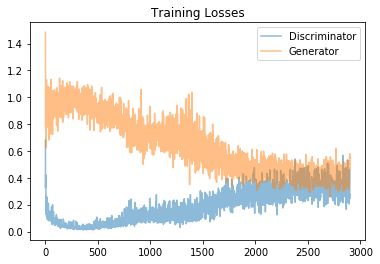

In [152]:
fig, ax = plt.subplots()
losses4 = np.array(losses4)
plt.plot(losses4.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses4.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [153]:
# Load samples from generator, taken while training
with open(save_file_name4, 'rb') as f:
    samples_config4 = pkl.load(f)

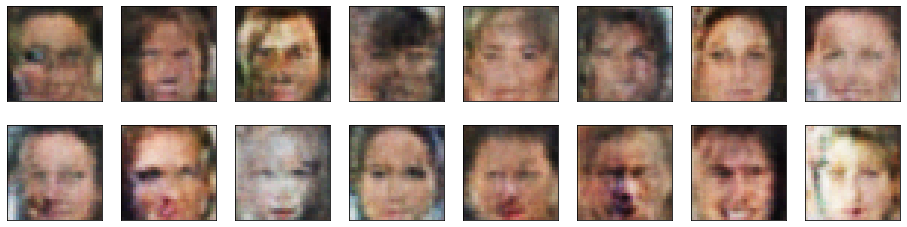

In [154]:
_ = view_samples(-1, samples_config4)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.